In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import PointClouds
import matplotlib
args= pd.Series({
    "dataset":"toy",
    "separable":"linear",
    "algorithm":"pc",
    "sd":1,
    "gamma":0.5,
    "tsh":0.95,
    "hard_thresholding":"False",
    "running_cluster":"True",
    "run":"toy_runs",
    "budget":"low",
    "n_epochs":100,
    "n_points":1000,
    "std":0.5,
    "eps":0.95,
    "cover_threshold":0.5,
    "reduction_method": "pessimistic"
    })

In [3]:
def get_toy_data(args):
    assert(args["std"] is not None)
    cluster_centers = [[0.5, 2], [1.5, 2], [3, 2.5], [3, 5], [5, 3], [5, 2], [3, 4], [4.5, 4.5], [1.5, 3.5], [0, 4]]
    cluster_centers = np.array(cluster_centers)
    cluster_std = np.repeat(args["std"], len(cluster_centers))
    cluster_samples = np.repeat(args.n_points, len(cluster_centers))

    dataset = PointClouds(cluster_centers, cluster_std, cluster_samples, random_state=1)
    dataset_test = PointClouds(cluster_centers, cluster_std, cluster_samples // 2, random_state=2)

    eval_freq = np.concatenate((np.repeat(1, 50), np.repeat(2, 25),
                                np.repeat(5, 20), np.repeat(10, 20),
                                np.repeat(50, 6), np.repeat(100, 3),
                                np.repeat(200, 10),
                                ))  # 3000
    if args.budget in ["high", "full"]:
        eval_freq = np.concatenate((eval_freq,
                                    np.repeat(200, 10),
                                    )) #5000
    if args.budget=="full":
        eval_freq = np.concatenate((eval_freq,
                                    np.repeat(500, 10),
                                    )) #10000
    idx= np.cumsum(eval_freq)
    return dataset, dataset_test, idx

def get_toy_path(args):
    std= args["std"]
    path_root= f"/Users/victoriabarenne/{args.run}/{args.dataset}_{args.separable}_{std}"
    if args.algorithm =="adpc":
        run_path= f"{path_root}/{args.n_epochs}_4_{args.tsh}_{args.hard_thresholding}_gamma{args.gamma}_{args.reduction_method}_{args.sd}"
    elif args.algorithm =="partialadpc":
        run_path= f"{path_root}/{args.n_epochs}_4_{args.tsh}_{args.hard_thresholding}_gamma{args.gamma}_{args.reduction_method}_{args.sd}"
    elif args.algorithm in ["benchmark", "random", "full"]:
        run_path= f"{path_root}/{args.n_epochs}_{args.sd}"
    elif args.algorithm == "pc":
        run_path= f"{path_root}/{args.n_epochs}_{args.tsh}_{args.sd}"
    elif args.algorithm == "coverpc":
        run_path= f"{path_root}/{args.n_epochs}_4_{args.tsh}_{args.hard_thresholding}_eps{args.eps}_cover{args.cover_threshold}_{args.sd}"
    return run_path

def fetching_run(args):
    run_path= get_toy_path(args)
    assert(args.algorithm in ["full", "random", "pc", "adpc", "partialadpc", "coverpc"])
    if args.algorithm=="full":
        scores = pd.read_csv(run_path + f"/full.csv", index_col=0)[f"full_scores"].to_numpy()
        queries, radiuses, degrees, options, covers = None, None, None, None, None
    else:
        scores = pd.read_csv(run_path + f"/{args.algorithm}_scores.csv", index_col=0)[f"{args.algorithm}_scores"].to_numpy()
        queries = pd.read_csv(run_path + f"/{args.algorithm}_queries.csv", index_col=0)[f"{args.algorithm}_queries"].to_numpy()
        if args.algorithm in ["pc", "adpc", "partialadpc", "coverpc"]:
            radiuses= np.load(f'{run_path}/{args.algorithm}_radiuses.npy')
            degrees = pd.read_csv(run_path + f"/{args.algorithm}_degrees.csv", index_col=0)[f"{args.algorithm}_degrees"].to_numpy()
            options = pd.read_csv(run_path + f"/{args.algorithm}_degrees.csv", index_col=0)[f"{args.algorithm}_options"].to_numpy()
            covers = pd.read_csv(run_path + f"/{args.algorithm}_covers.csv", index_col=0)[f"{args.algorithm}_covers"].to_numpy()
        else:
            radiuses, degrees, options, covers= None, None, None, None

    return scores, queries, radiuses, degrees, options, covers

def fetching_aggregated_run(args, n_seeds=5):
    if args.budget=="high":
        n_queries=5000
        n_saves= 144
    elif args.budget=="full":
        n_queries=10000
        n_saves=154
    elif args.budget=="low":
        n_queries=3000
        n_saves= 134

    scores, queries= np.empty(shape=(n_saves, n_seeds)), np.empty(shape=(n_queries, n_seeds))
    if args.algorithm=="adpc":
        radiuses= np.empty(shape=(10000, n_saves, n_seeds))
    elif args.algorithm=="pc":
        radiuses= np.empty(shape=(n_seeds,))
    elif args.algorithm=="coverpc":
        radiuses= np.empty(shape=(n_saves,n_seeds))
    else:
        radiuses= None
    degrees, options= np.empty(shape= (n_queries, n_seeds)), np.empty(shape= (n_queries, n_seeds))
    covers= np.empty(shape=(n_saves, n_seeds))
    for sd in range(n_seeds):
        args.sd=sd+1
        sco, que, rad, deg, opt, cov= fetching_run(args)
        scores[:,sd] = sco[:n_saves]
        if args.algorithm!="full":
            queries[:,sd]= que[:n_queries]
        if args.algorithm in ["adpc", "pc", "coverpc"]:
            degrees[:,sd], options[:,sd], covers[:,sd] = deg[:n_queries], opt[:n_queries], cov[:n_saves]
            if args.algorithm =="adpc":
                radiuses[:,:,sd]= rad[:,:n_saves]
            elif args.algorithm=="pc":
                radiuses[sd]= rad
            elif args.algorithm=="coverpc":
                radiuses[:,sd]= rad[:n_saves]
    return scores, queries, radiuses, degrees, options, covers


In [4]:
def add_score_line(args, label, n_seeds= 5, color=None, type="scores"):
    scores, _, _, degrees, options, covers= fetching_aggregated_run(args, n_seeds=n_seeds)
    if type in ["degrees", "options"]:
        y = degrees if type=="degrees" else options
        idx = np.arange(1, len(degrees)+1)
    elif type in ["scores", "covers"]:
        _, _, idx= get_toy_data(args)
        y= scores if type=="scores" else covers
    sns.lineplot(x=idx, y=y.mean(-1), label= label, color=color, linewidth= 2)
    plt.fill_between(idx, y.mean(-1)+ y.std(-1), y.mean(-1)- y.std(-1), alpha=0.5, color=color)

## 0. Toy datasets plots

In [ ]:
save= False
train= False

for separable in ["linear", "not"]:
    stds= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] if separable=="linear" else [0.2, 0.3, 0.4, 0.5, 0.6]
    args.separable= separable
    for std in stds:
        args["std"]= std
        dataset_train, dataset_test, _= get_toy_data(args)
        dataset= dataset_train if train else dataset_test
        fig, ax = plt.subplots()
        ax.axis('equal')
        ax.set_xlim(-2.5, 7)
        ax.set_ylim(0,7.5)
        sns.scatterplot(x=dataset.x[:, 0], y=dataset.x[:, 1], hue=dataset.y, palette="Set3", alpha= 0.9, s=20)
        # plt.legend(loc= "lower left")
        plt.legend('',frameon=False)

        if save:
            type="train" if train else "test"
            plt.savefig(f"/Users/victoriabarenne/thesis_plots/toy_runs/datasets/no_legend/{type}_{separable}_{std}.png")
            plt.close()
        else:
            plt.show()

## 1. Radiuses Heatmaps


In [21]:
def plot_adpc_radiuses_heatmap(args, sd, save=True):
    args.sd= sd
    args.algorithm, args.tsh, args.run= "adpc", 0.25, "thesis_experiments/toy_runs"
    _, queries, radiuses, _, _, _= fetching_run(args)
    dataset, dataset_test, idx= get_toy_data(args)

    dataset.observe(queries)
    dataset.radiuses= radiuses[:, -1]

    sns.scatterplot(x= dataset.x[:,0], y= dataset.x[:,1], hue= dataset.radiuses, palette="Spectral",
                    size=1, alpha=0.9)
    if save:
        std= args["std"]
        plt.savefig(f"/Users/victoriabarenne/thesis_plots/toy_runs/radiuses_heatmaps/{args.separable}_{std}_{args.sd}.png")
        plt.close()
    else:
        plt.show()

In [ ]:
for separable in ["linear", "not"]:
    stds= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] if separable=="linear" else [0.2, 0.3, 0.4, 0.5, 0.6]
    args.separable= separable
    for std in stds:
        args["std"]= std
        plot_adpc_radiuses_heatmap(args, 1, save=False)

## 2. Adpc radius aggregates

In [23]:
def plot_adpc_radiuses(args, n_seeds=5, save=False):
    args.algorithm, args.tsh, args.budget= "adpc", 0.25, "high"
    _, queries, radiuses, _, _, _= fetching_aggregated_run(args, n_seeds)
    _, _, idx= get_toy_data(args)
    sns.lineplot(x=idx, y=radiuses.mean(0).mean(-1), label="Mean radius")
    plt.fill_between(idx, radiuses.mean(0).mean(-1)+ radiuses.mean(0).std(-1), radiuses.mean(0).mean(-1)- radiuses.mean(0).std(-1), alpha=0.5)

    sns.lineplot(x=idx, y=radiuses.max(0).mean(-1), label="Max radius")
    plt.fill_between(idx, radiuses.max(0).mean(-1)+ radiuses.max(0).std(-1), radiuses.max(0).mean(-1)- radiuses.max(0).std(-1), alpha=0.5)

    sns.lineplot(x=idx, y=radiuses.min(0).mean(-1), label="Min radius")
    plt.fill_between(idx, radiuses.min(0).mean(-1)+ radiuses.min(0).std(-1), radiuses.min(0).mean(-1)- radiuses.min(0).std(-1), alpha=0.5)
    plt.legend()
    plt.xscale("log")
    if save:
        std= args["std"]
        plt.savefig(f"/Users/victoriabarenne/thesis_plots/toy_runs/radius_aggregates/{args.separable}_{std}.png")
        plt.close()
    else:
        plt.show()

In [ ]:
for separable in ["linear", "not"]:
    args.separable= separable
    stds= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] if separable=="linear" else [0.2, 0.3, 0.4, 0.5, 0.6]
    for std in stds:
        args["std"]= std
        plot_adpc_radiuses(args, save=False)

## 3. Adpc scores

In [8]:
def plot_cifar_performance(args, std, separable, type="scores", save=False, zoom=False):
    args.std, args.separable, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh, args.run= std, separable, 100, "False", "low", 0.5, "pessimistic", 0.5, 0.9, 0.25, "toy_runs"
    args_adpc, args_coverpc, args_pc, args_random, args_full= args.copy(), args.copy(), args.copy(), args.copy(), args.copy()
    args_adpc.algorithm, args_adpc.hard_thresholding= "adpc", "True"
    args_coverpc.algorithm= "coverpc"
    args_pc.algorithm, args_pc.tsh= "pc", 0.95
    args_random.algorithm, args_full.algorithm= "random", "full"

    cmap=matplotlib.colormaps["Set2"]
    if zoom:
        save_root = f"/Users/victoriabarenne/thesis_plots/toy_runs/performance/zoom/"
    else:
        save_root = f"/Users/victoriabarenne/thesis_plots/toy_runs/performance/"

    add_score_line(args_adpc, "Adaptive PC", type=type, color=cmap.colors[2])
    add_score_line(args_pc, "PC", type=type, color=cmap.colors[3])
    add_score_line(args_coverpc, "Dynamic PC", type=type, color=cmap.colors[4])
    if type=="scores":
        add_score_line(args_random, "Random", type=type, color=cmap.colors[5])
        add_score_line(args_full, "Oracle", type=type, color= cmap.colors[6])
    plt.xscale("log")

    location= {"scores": "lower right",
              "covers": "upper left",
               "degrees": "upper right",
               "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}

    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])

    if type=="scores":
        (ymin, ymax)= (0.6, 0.9) if dataset=="cifar10" else (0.15, 0.6)
    elif type=="covers":
        ymax= 0.8 if dataset=="cifar10" else 0.75

    if zoom and type in ["scores", "covers"]:
        plt.xlim(500, 15000)
        plt.ylim(ymin, ymax)
    elif type in ["scores", "covers"]:
        plt.ylim(0,ymax)

    if save:
        plt.savefig(save_root + f"{args.n_epochs}_{args.dataset}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}epochs_{type}")
        plt.show()

In [9]:
plot_cifar_performance(args, 0.5, "linear")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/victoriabarenne/toy_runs/toy_linear_0.5/100_4_0.25_True_gamma0.5_pessimistic_1/adpc_scores.csv'

## 4. CoverPC

In [42]:
def plot_coverpc_performance(args, n_seeds=1, save=False):
    args_pc=args.copy()
    args_pc.algorithm, args_pc.threshold, args_pc.run= "pc", 0.95, "thesis_experiments/toy_runs"
    _, _, idx=  get_toy_data(args)
    for cover_threshold in [0.3, 0.5, 0.7]:
        args.cover_threshold=cover_threshold
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (30,10))
        for eps in [0.7, 0.8, 0.9, 0.95]:
            args.eps= eps
            scores, _, _, _, _, covers= fetching_aggregated_run(args, n_seeds=n_seeds)
            sns.lineplot(x=idx, y= scores.mean(-1), label= f"eps {eps}", ax=ax1)
            ax1.fill_between(idx, scores.mean(-1)+ scores.std(-1), scores.mean(-1)- scores.std(-1), alpha=0.5)
            sns.lineplot(x=idx, y= covers.mean(-1), label= f"eps {eps}", ax=ax2)
            ax2.fill_between(idx, covers.mean(-1)+ covers.std(-1), covers.mean(-1)- covers.std(-1), alpha=0.5)

        scores, _, _, _, _, covers= fetching_aggregated_run(args_pc, n_seeds=n_seeds)
        sns.lineplot(x=idx, y=scores.mean(-1), label= f"PC", ax=ax1)
        ax1.fill_between(idx, scores.mean(-1)+ scores.std(-1), scores.mean(-1)- scores.std(-1), alpha=0.5)
        sns.lineplot(x=idx, y=covers.mean(-1), label= f"PC", ax=ax2)
        ax2.fill_between(idx, covers.mean(-1)+ covers.std(-1), covers.mean(-1)- covers.std(-1), alpha=0.5)

        plt.legend(loc= "upper left")
        ax1.set_xscale("log")
        ax2.set_xscale("log")

        if save:
            plt.savefig(f"/Users/victoriabarenne/thesis_plots/toy_runs/pc_performance/{args.separable}_{args.std}_{args.cover_threshold}_scores.png")
            plt.close()
        else:
            plt.title(f"Dataset {args.separable} with std {args.std}")
            plt.show()


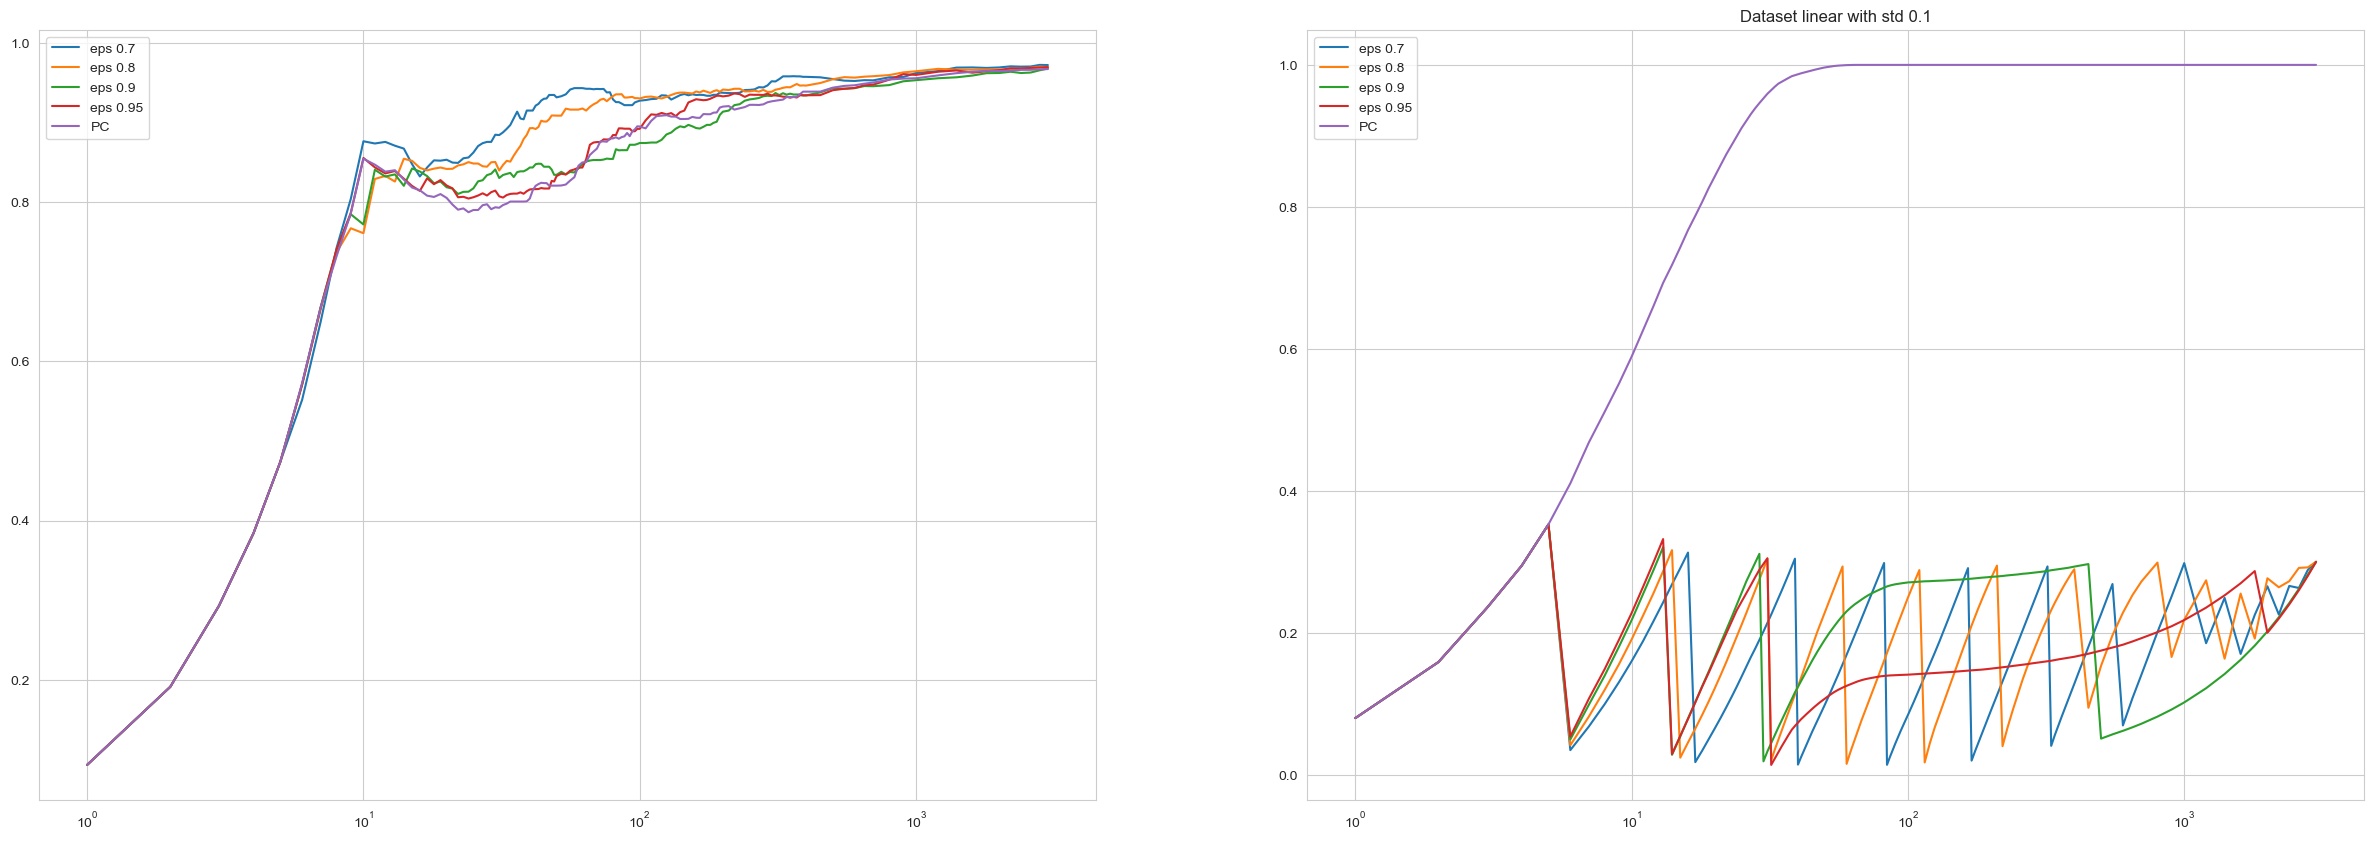

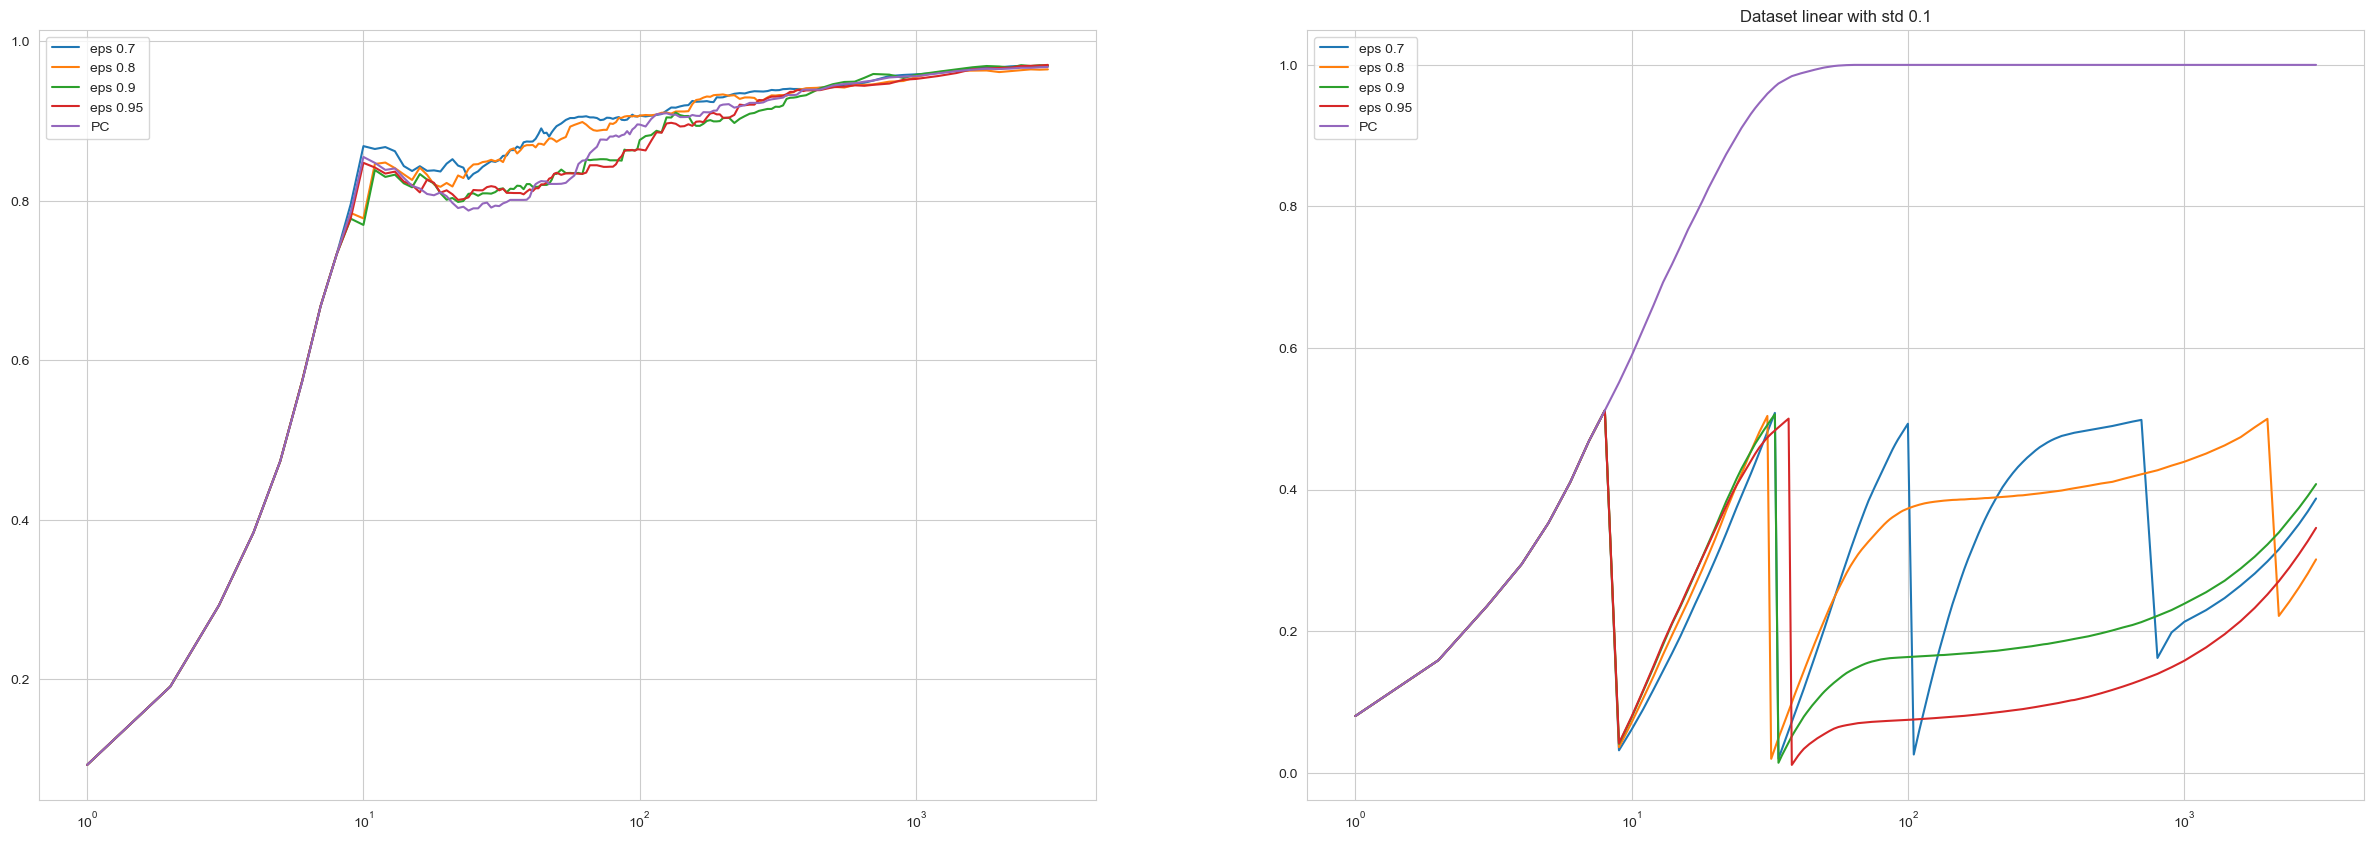

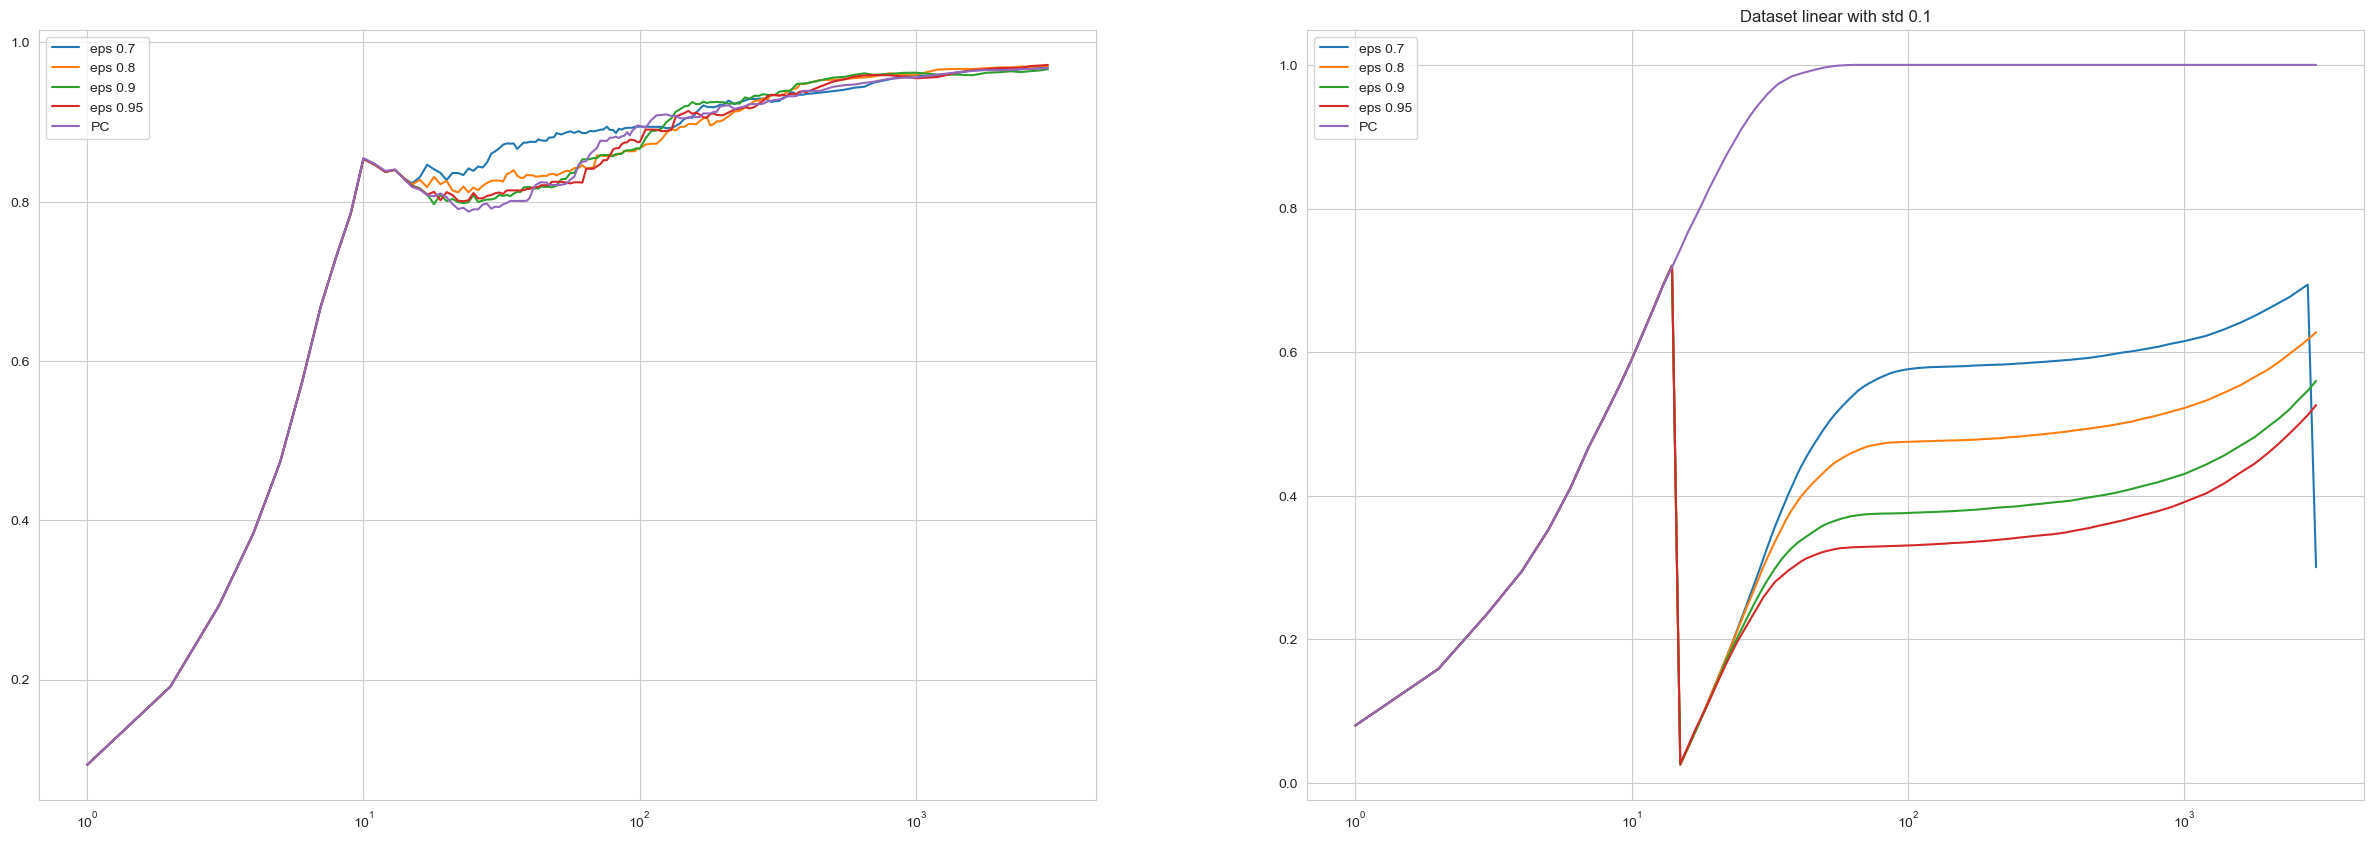

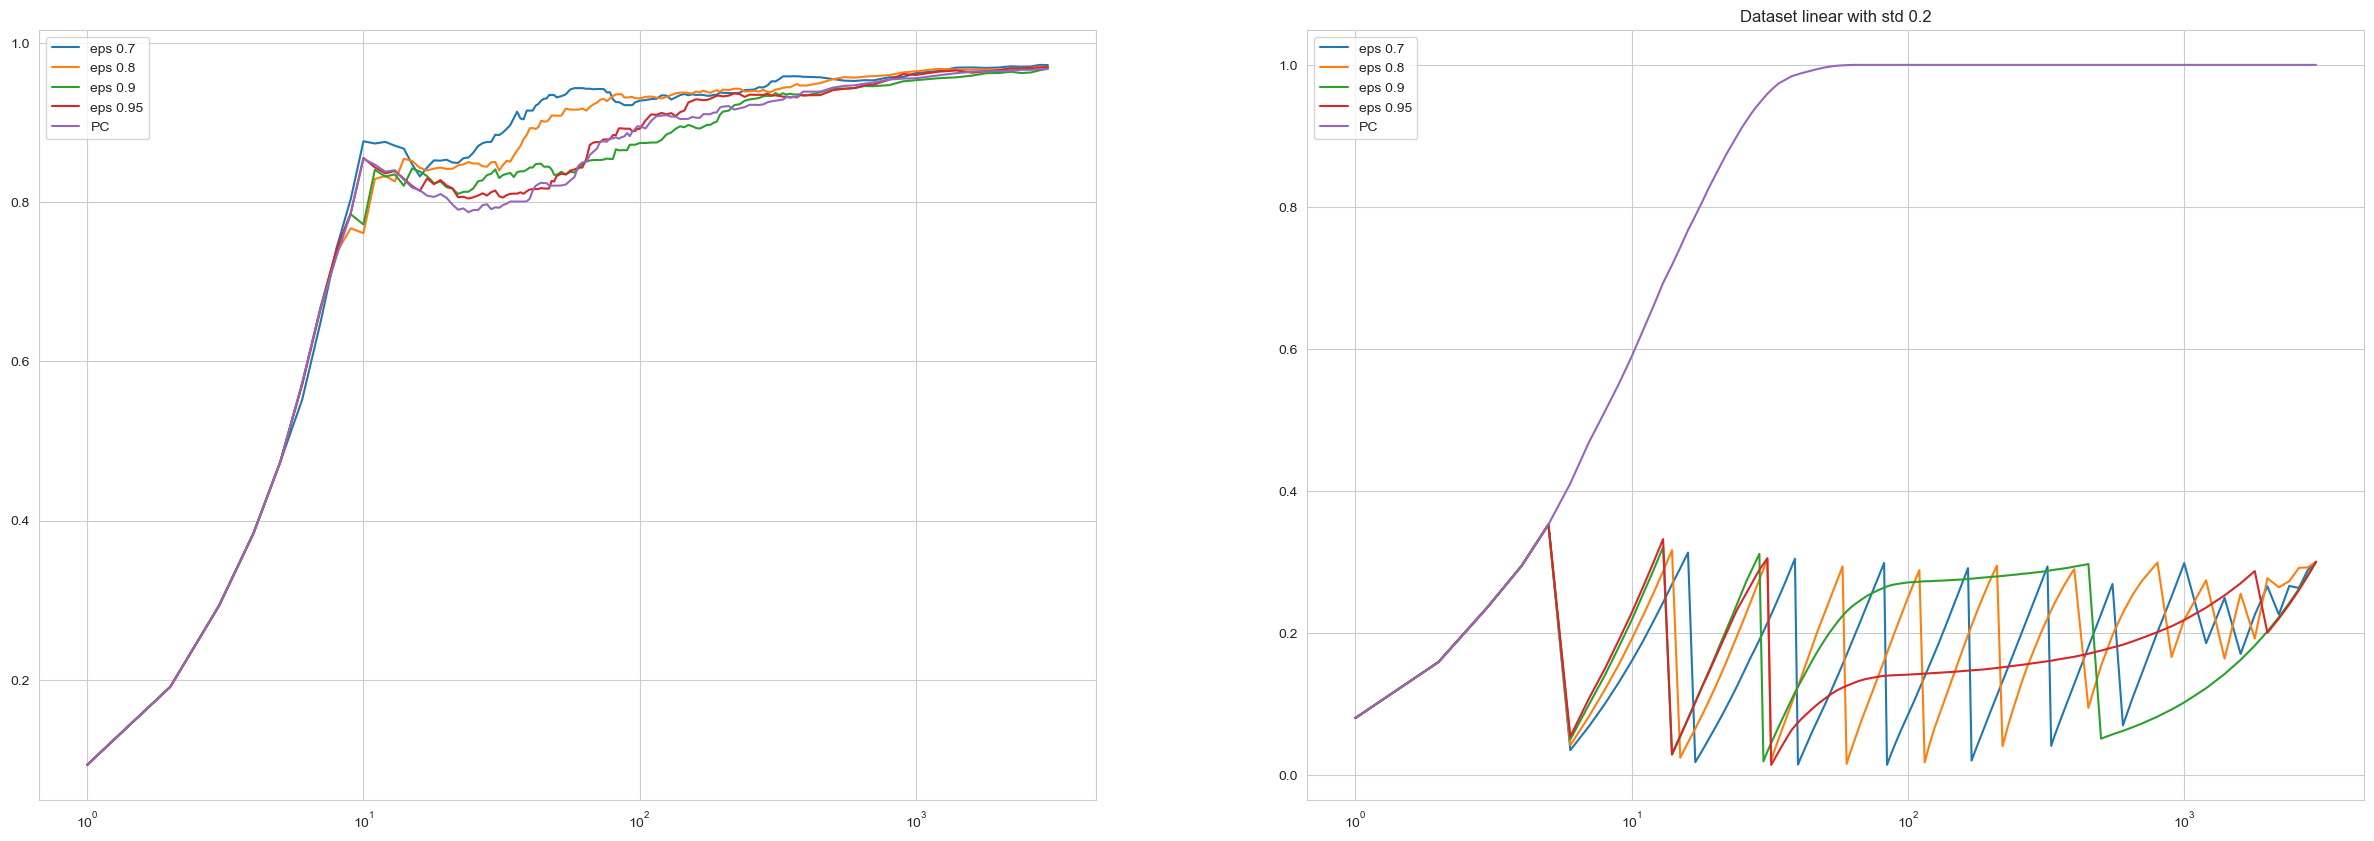

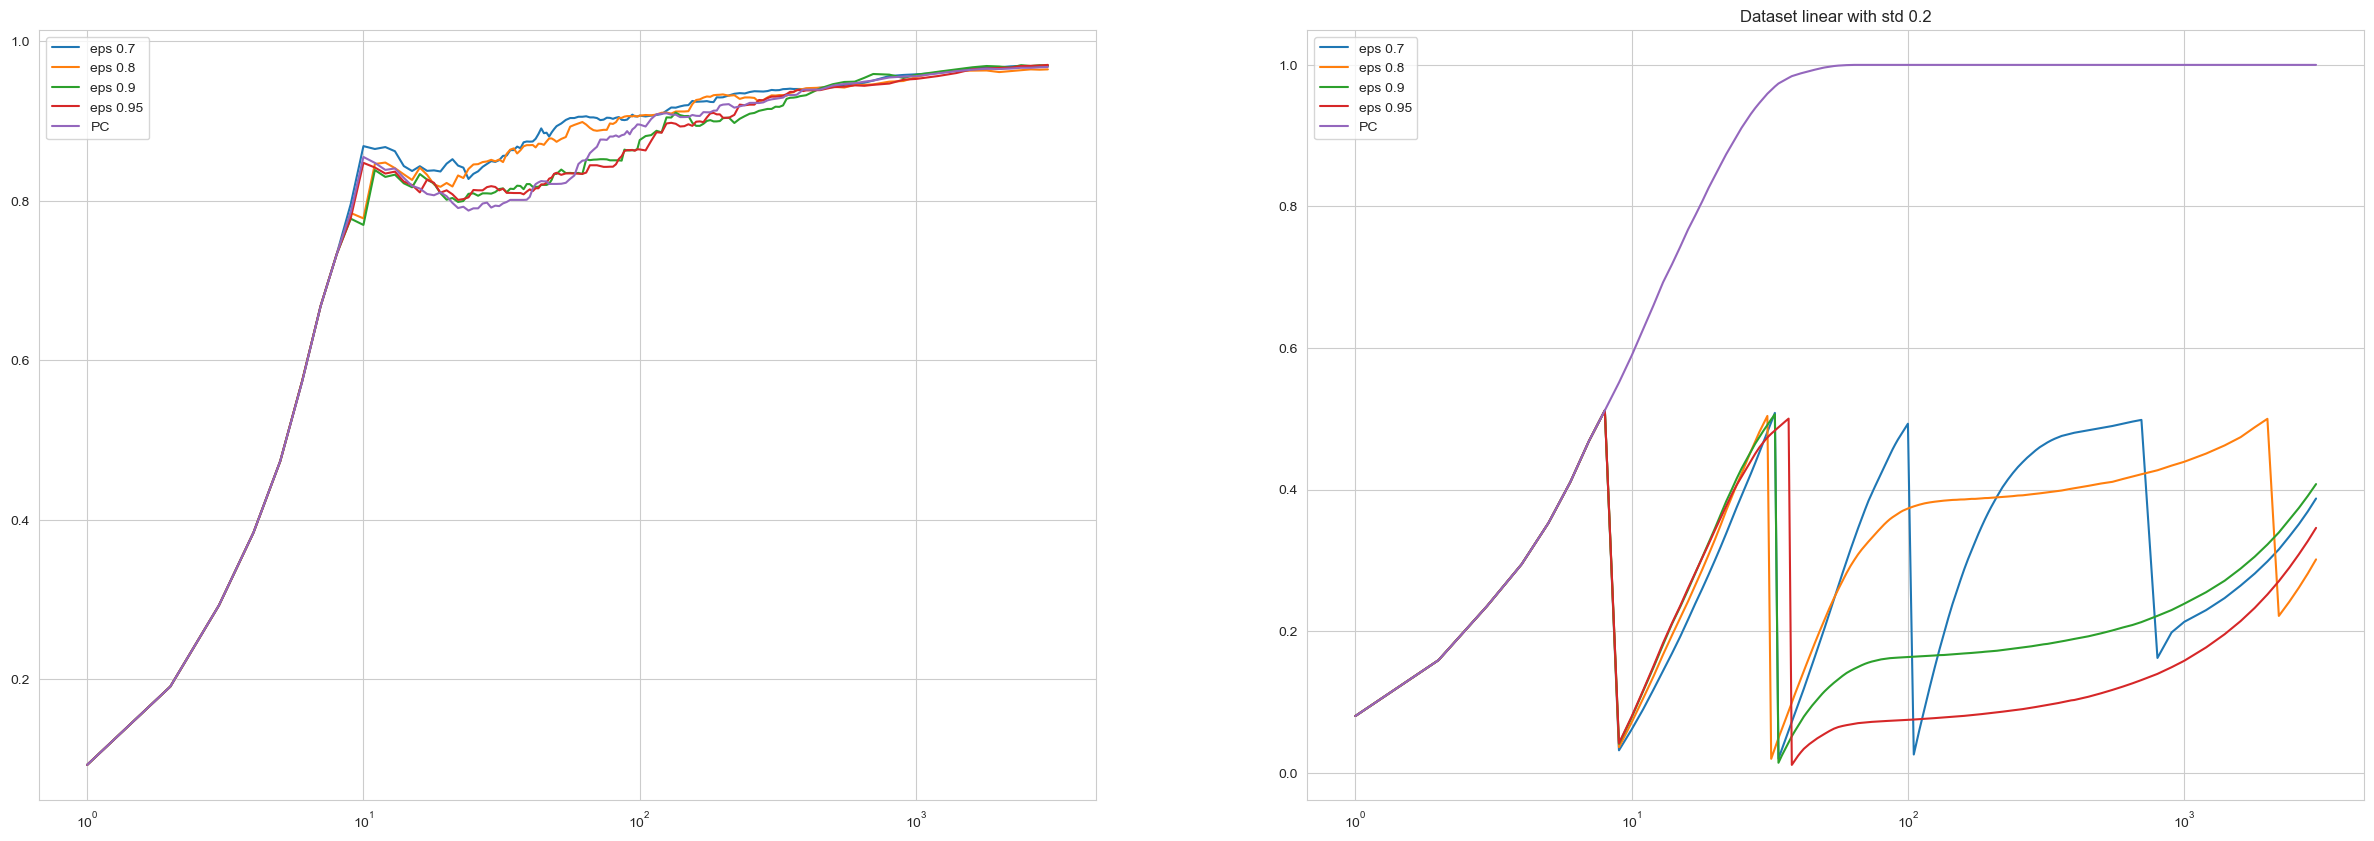

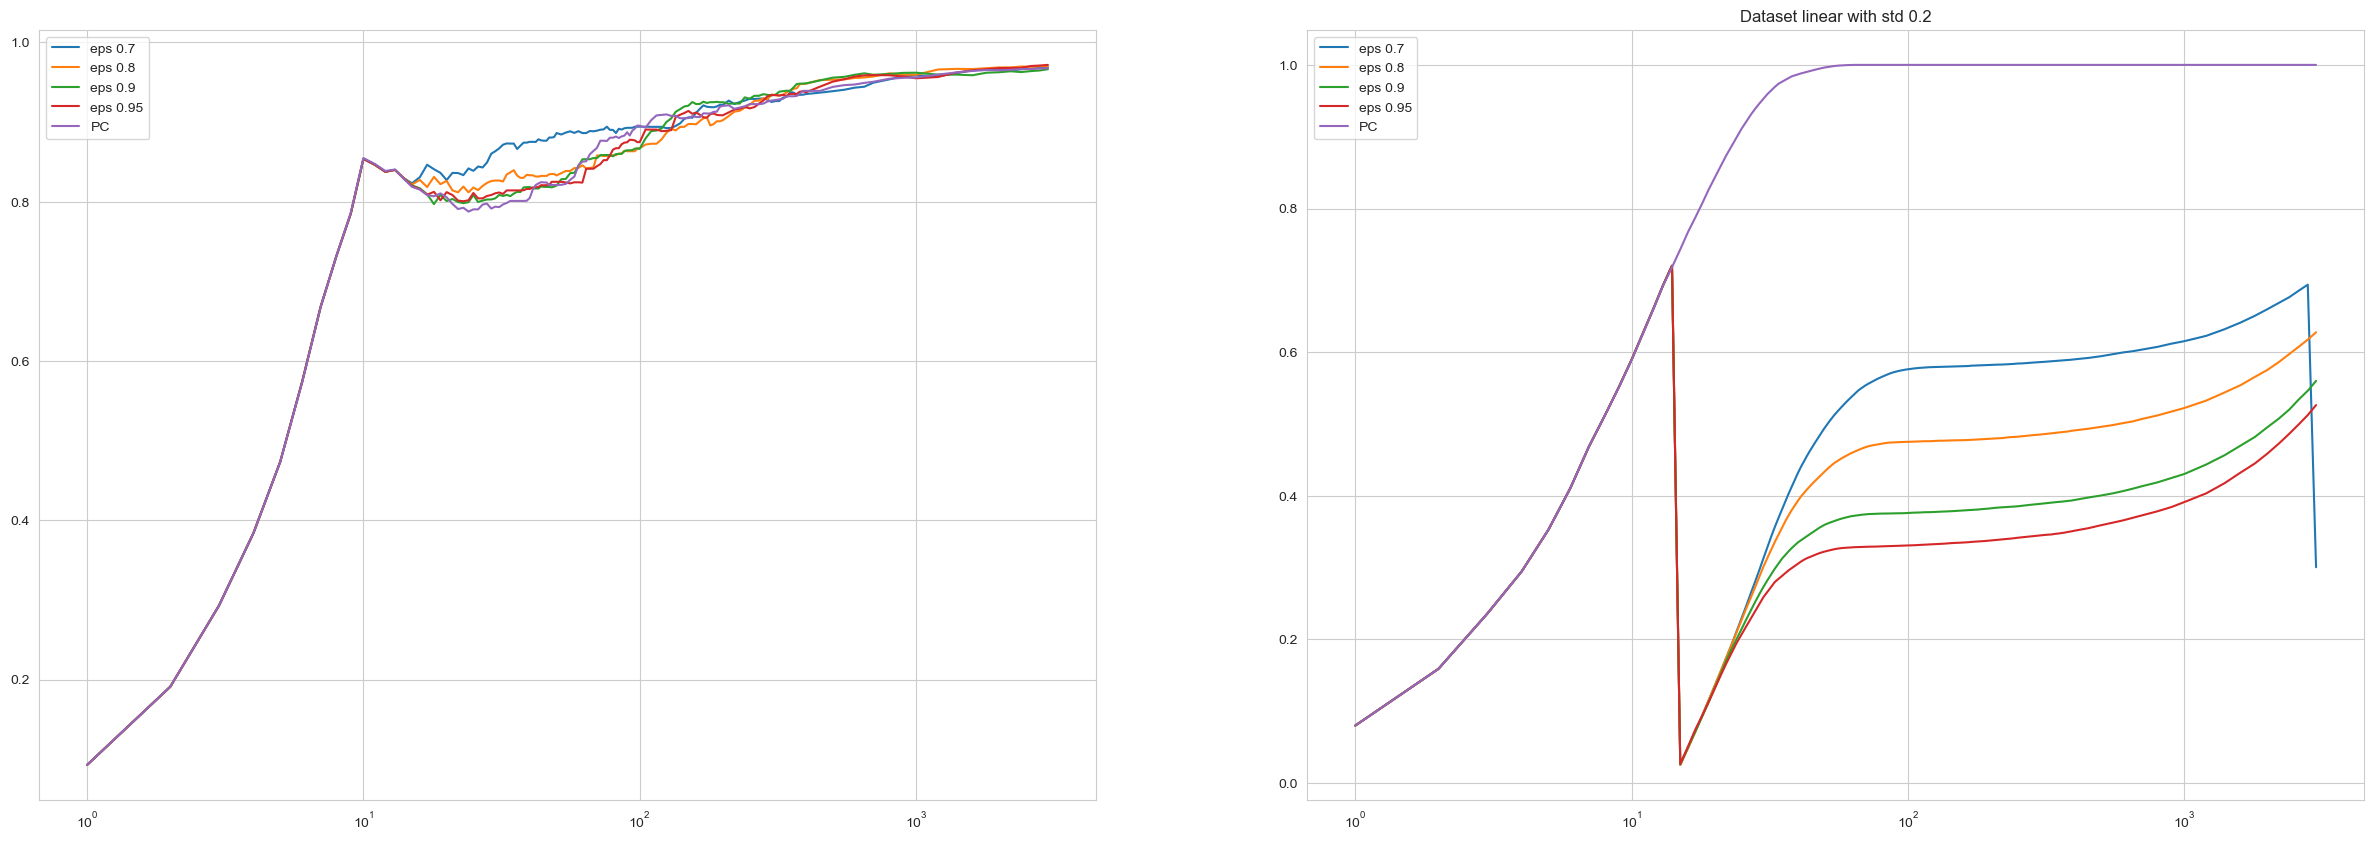

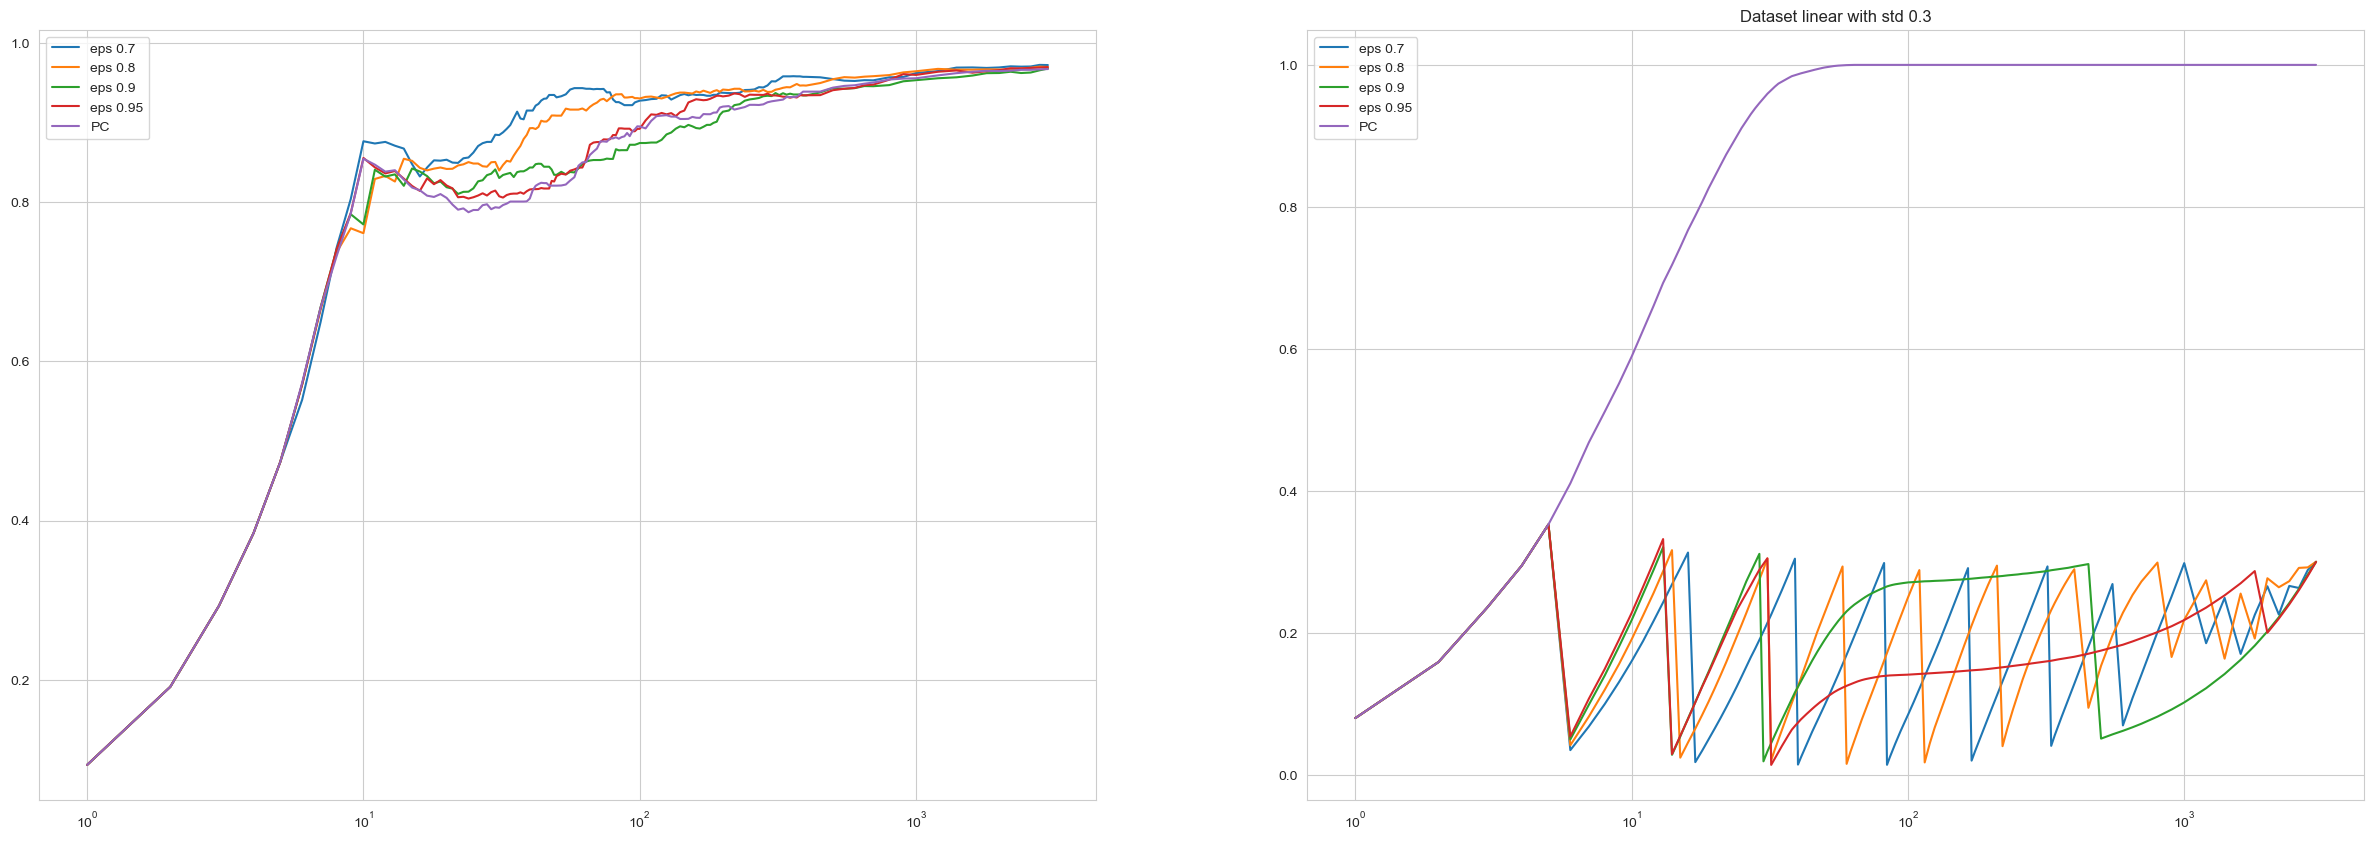

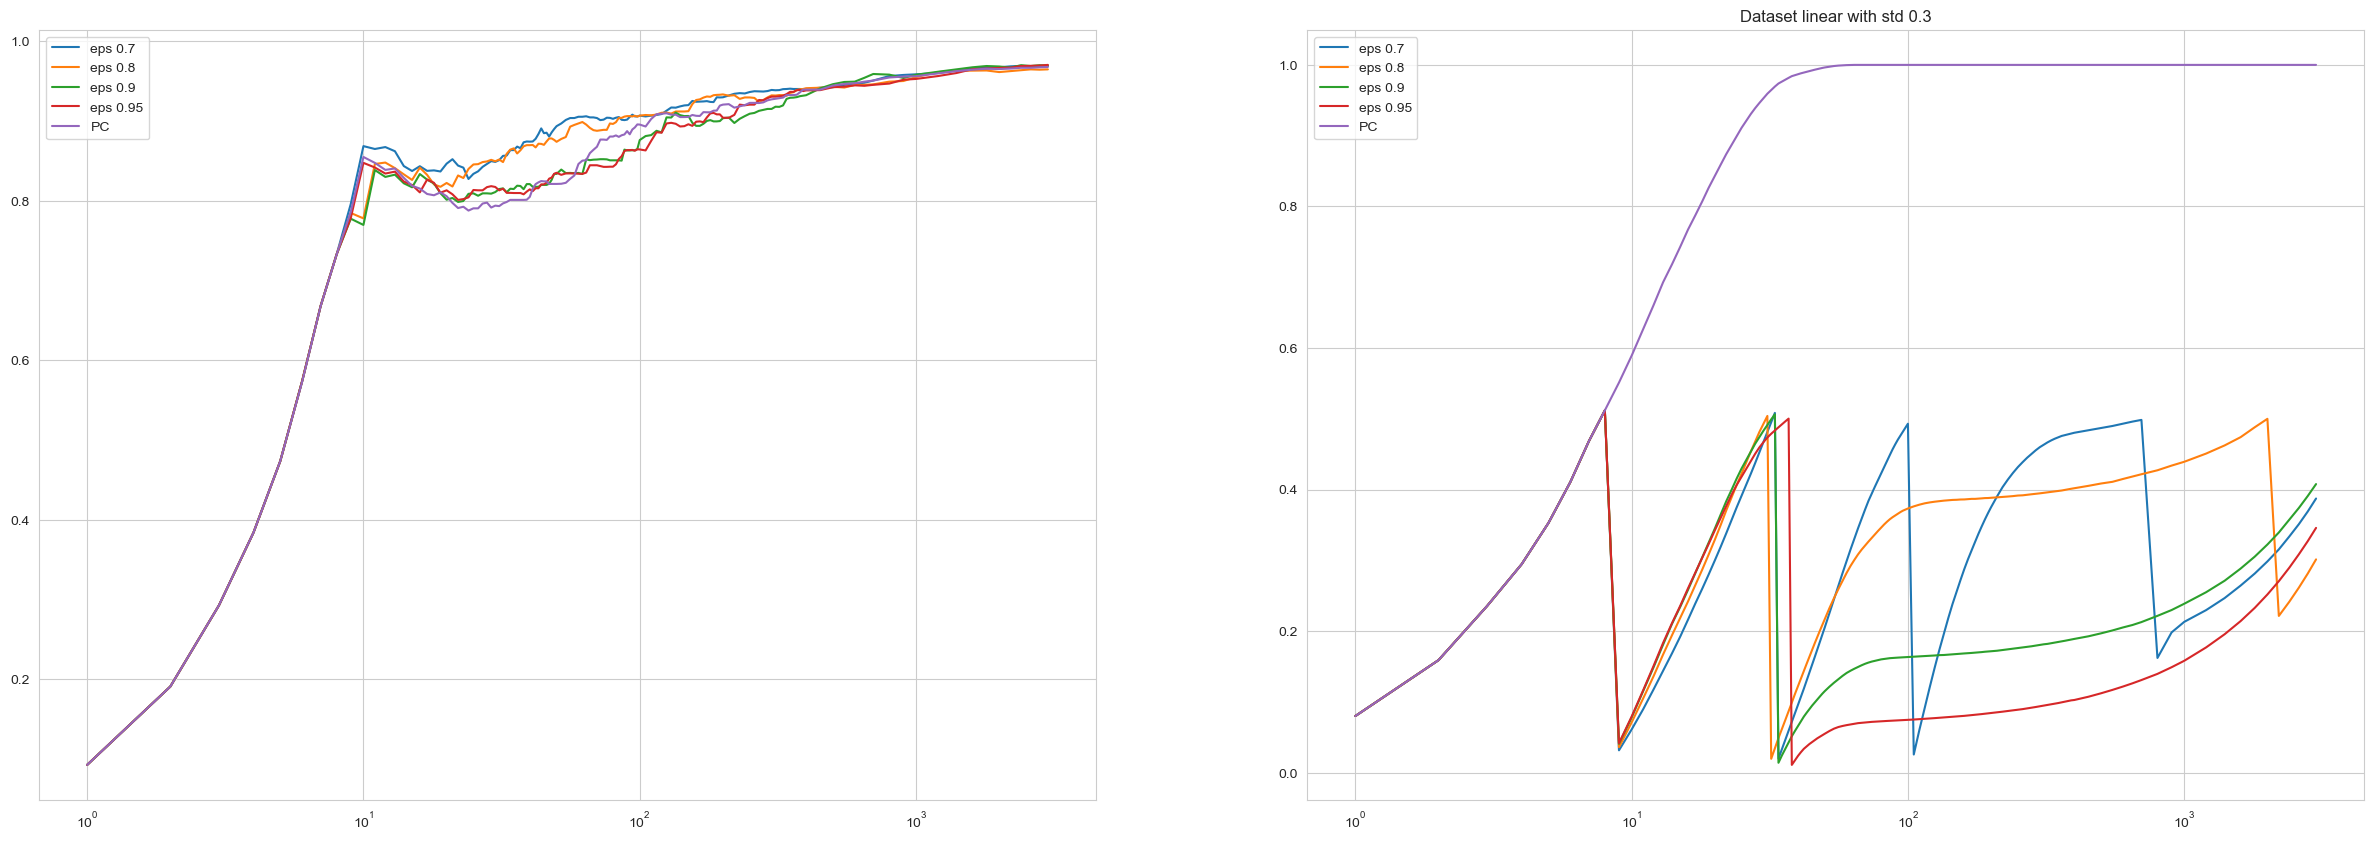

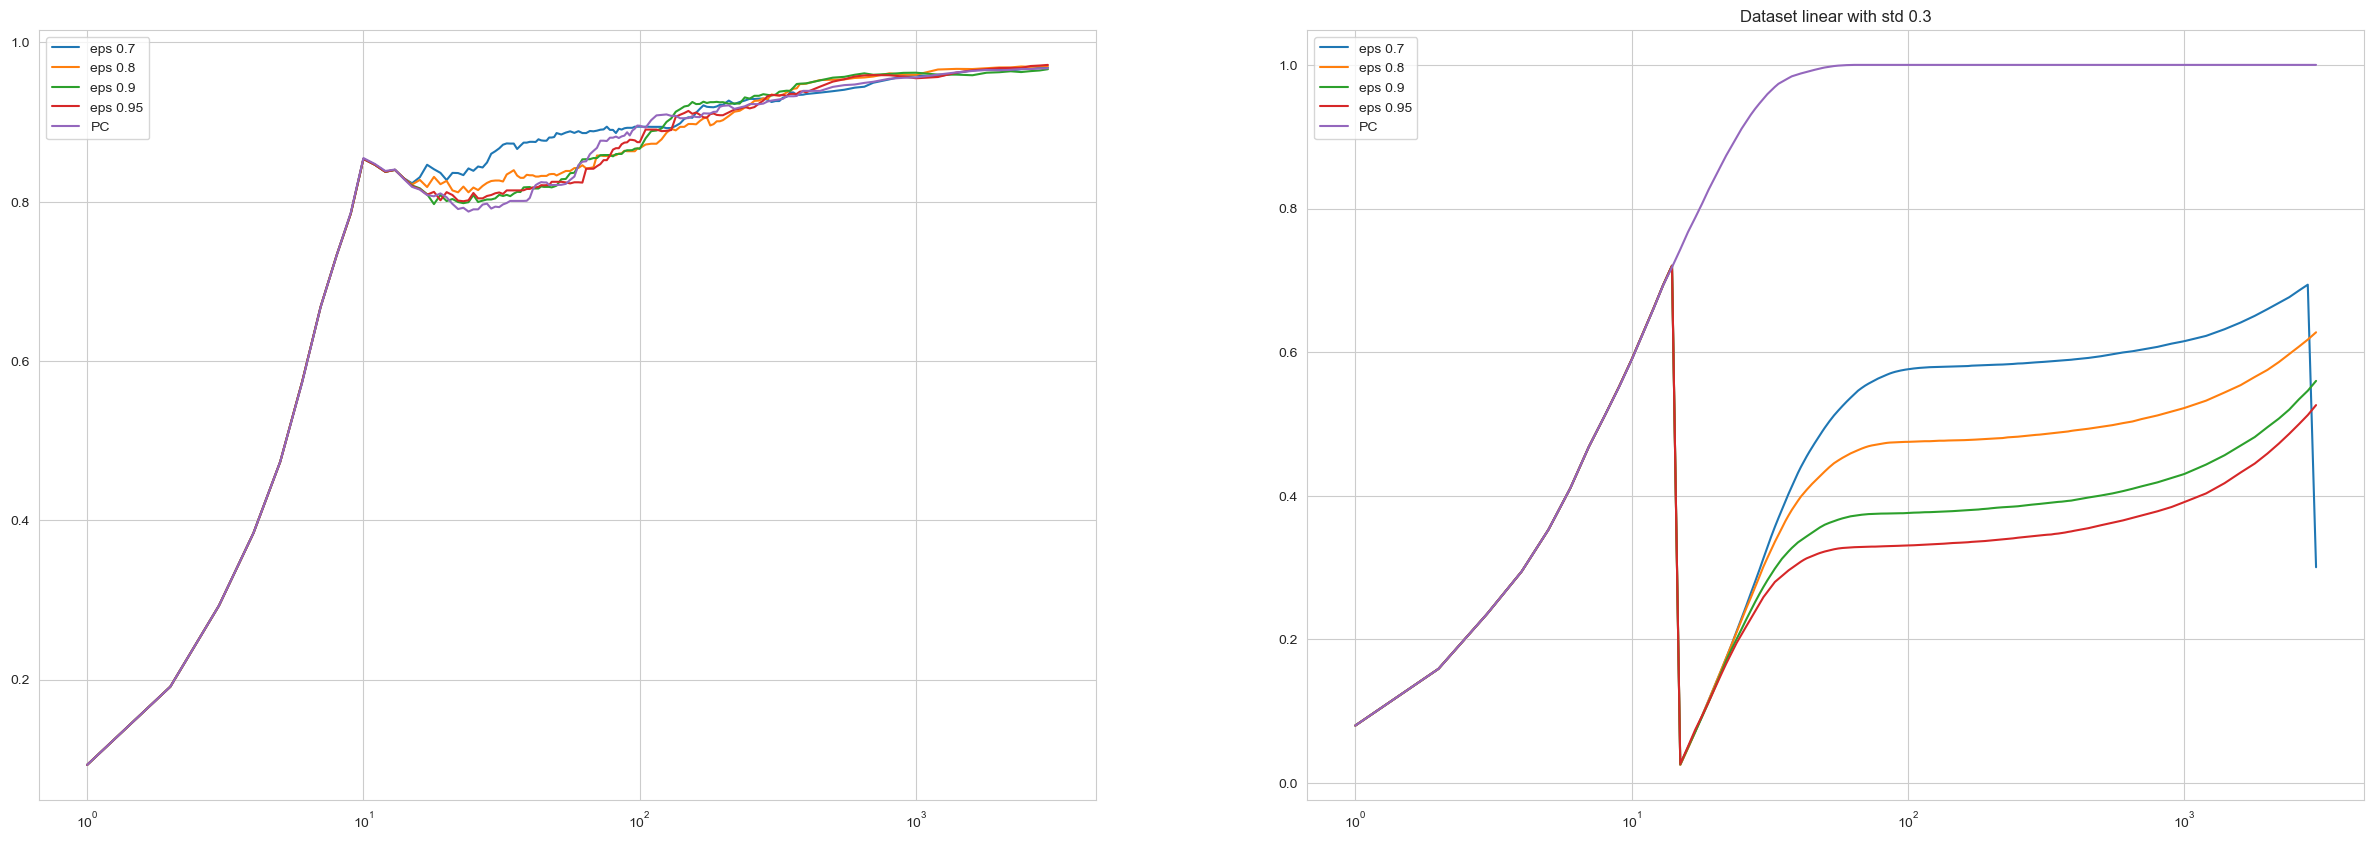

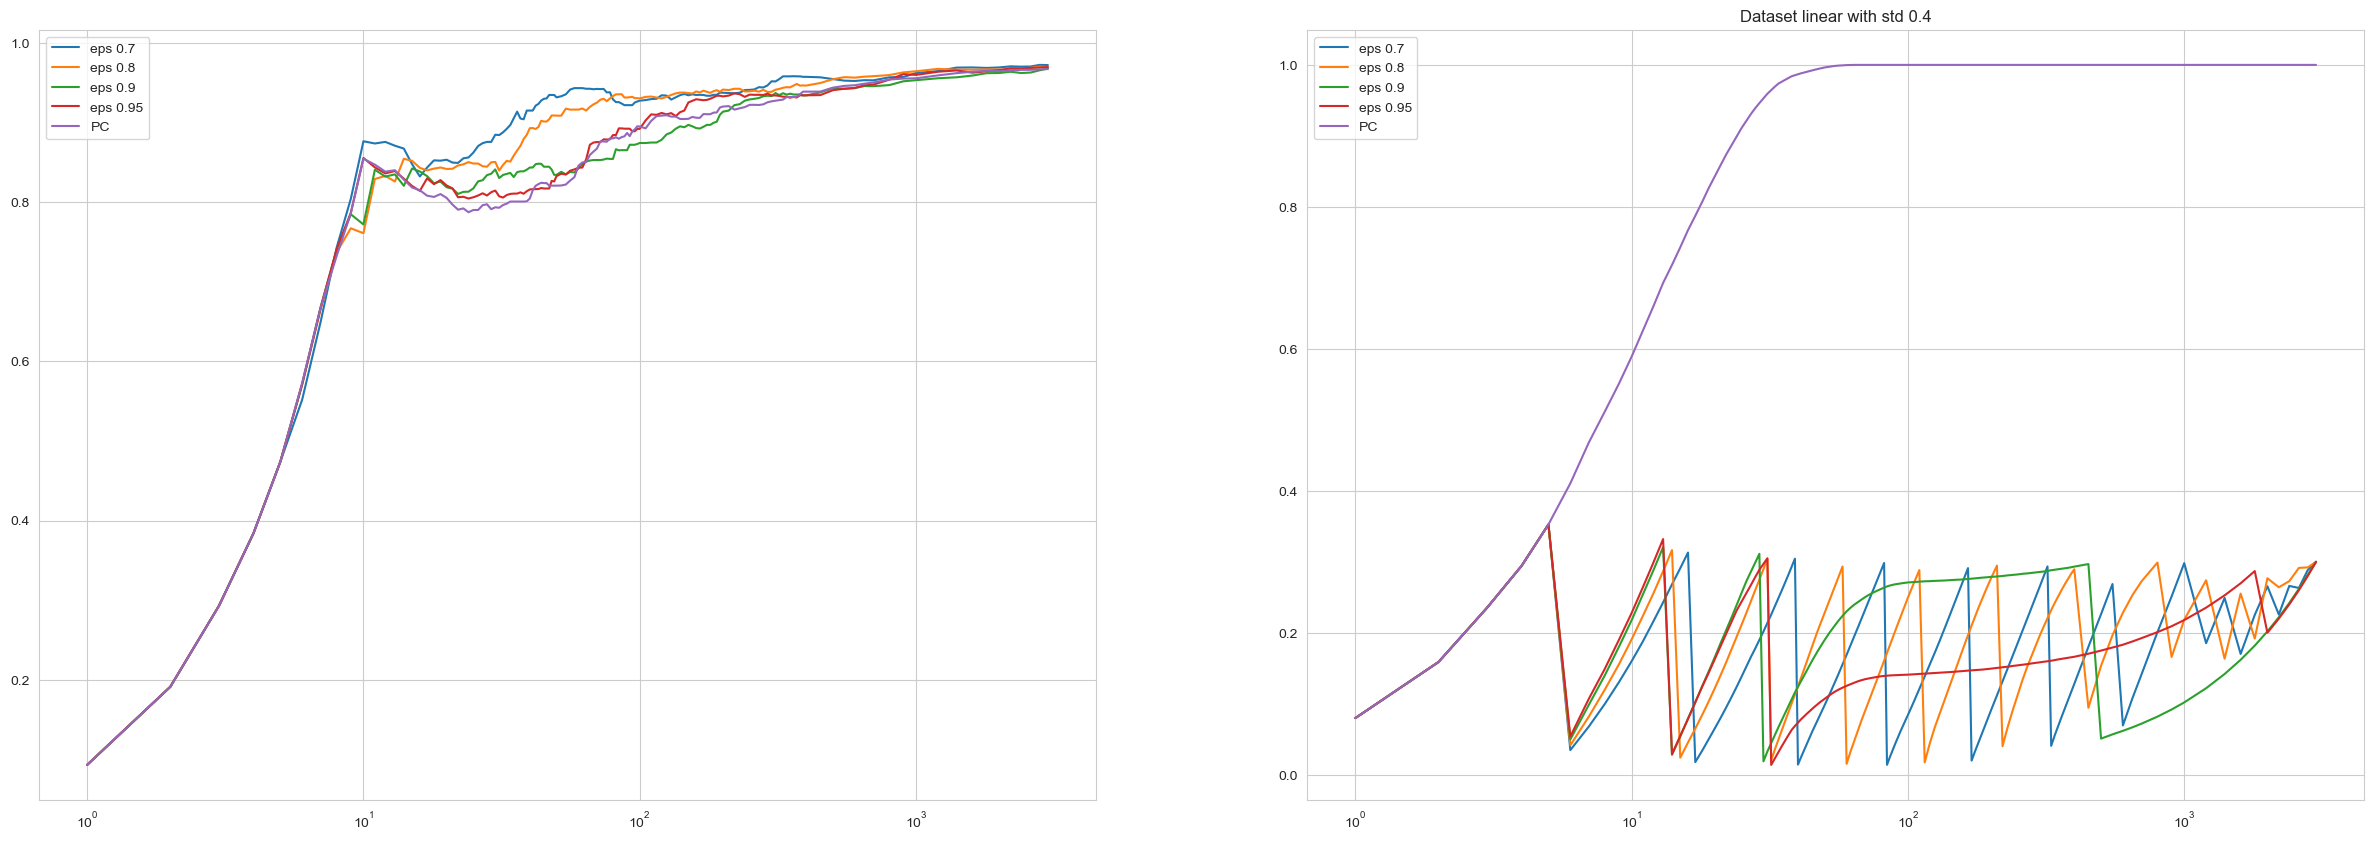

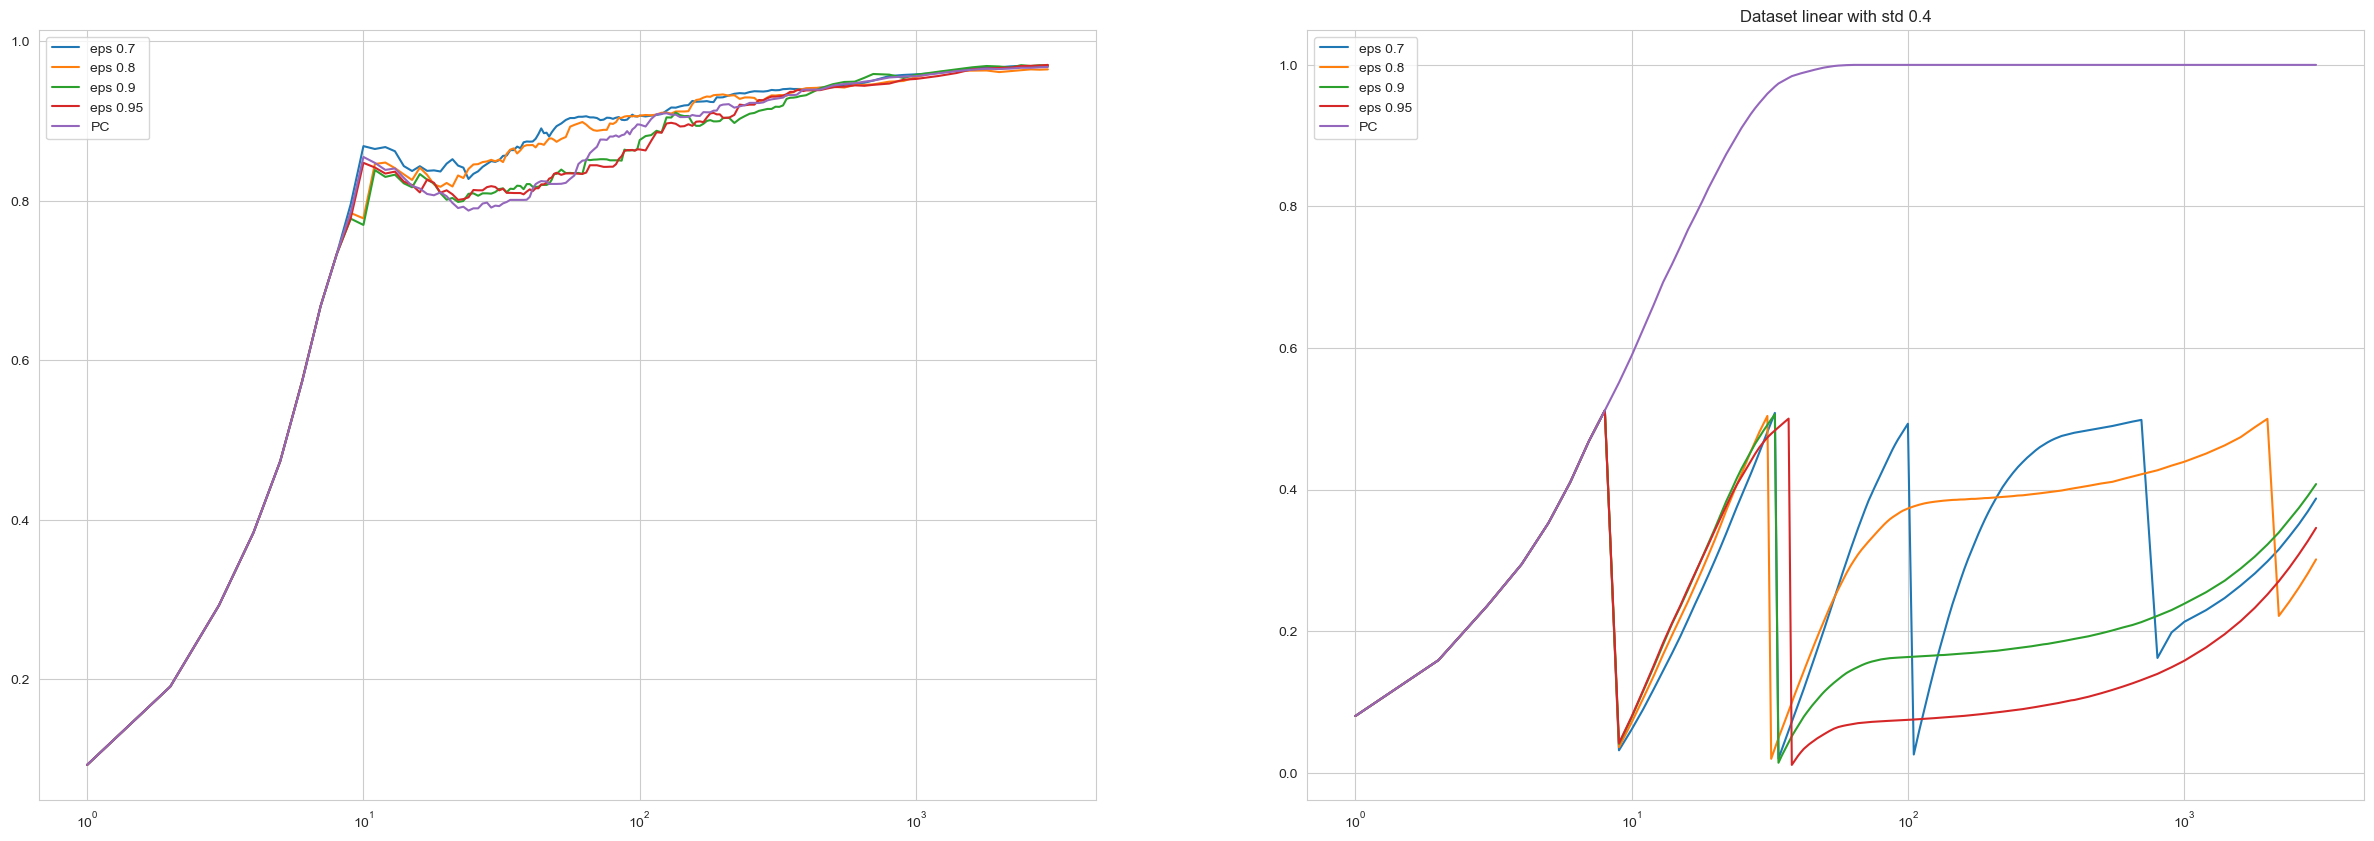

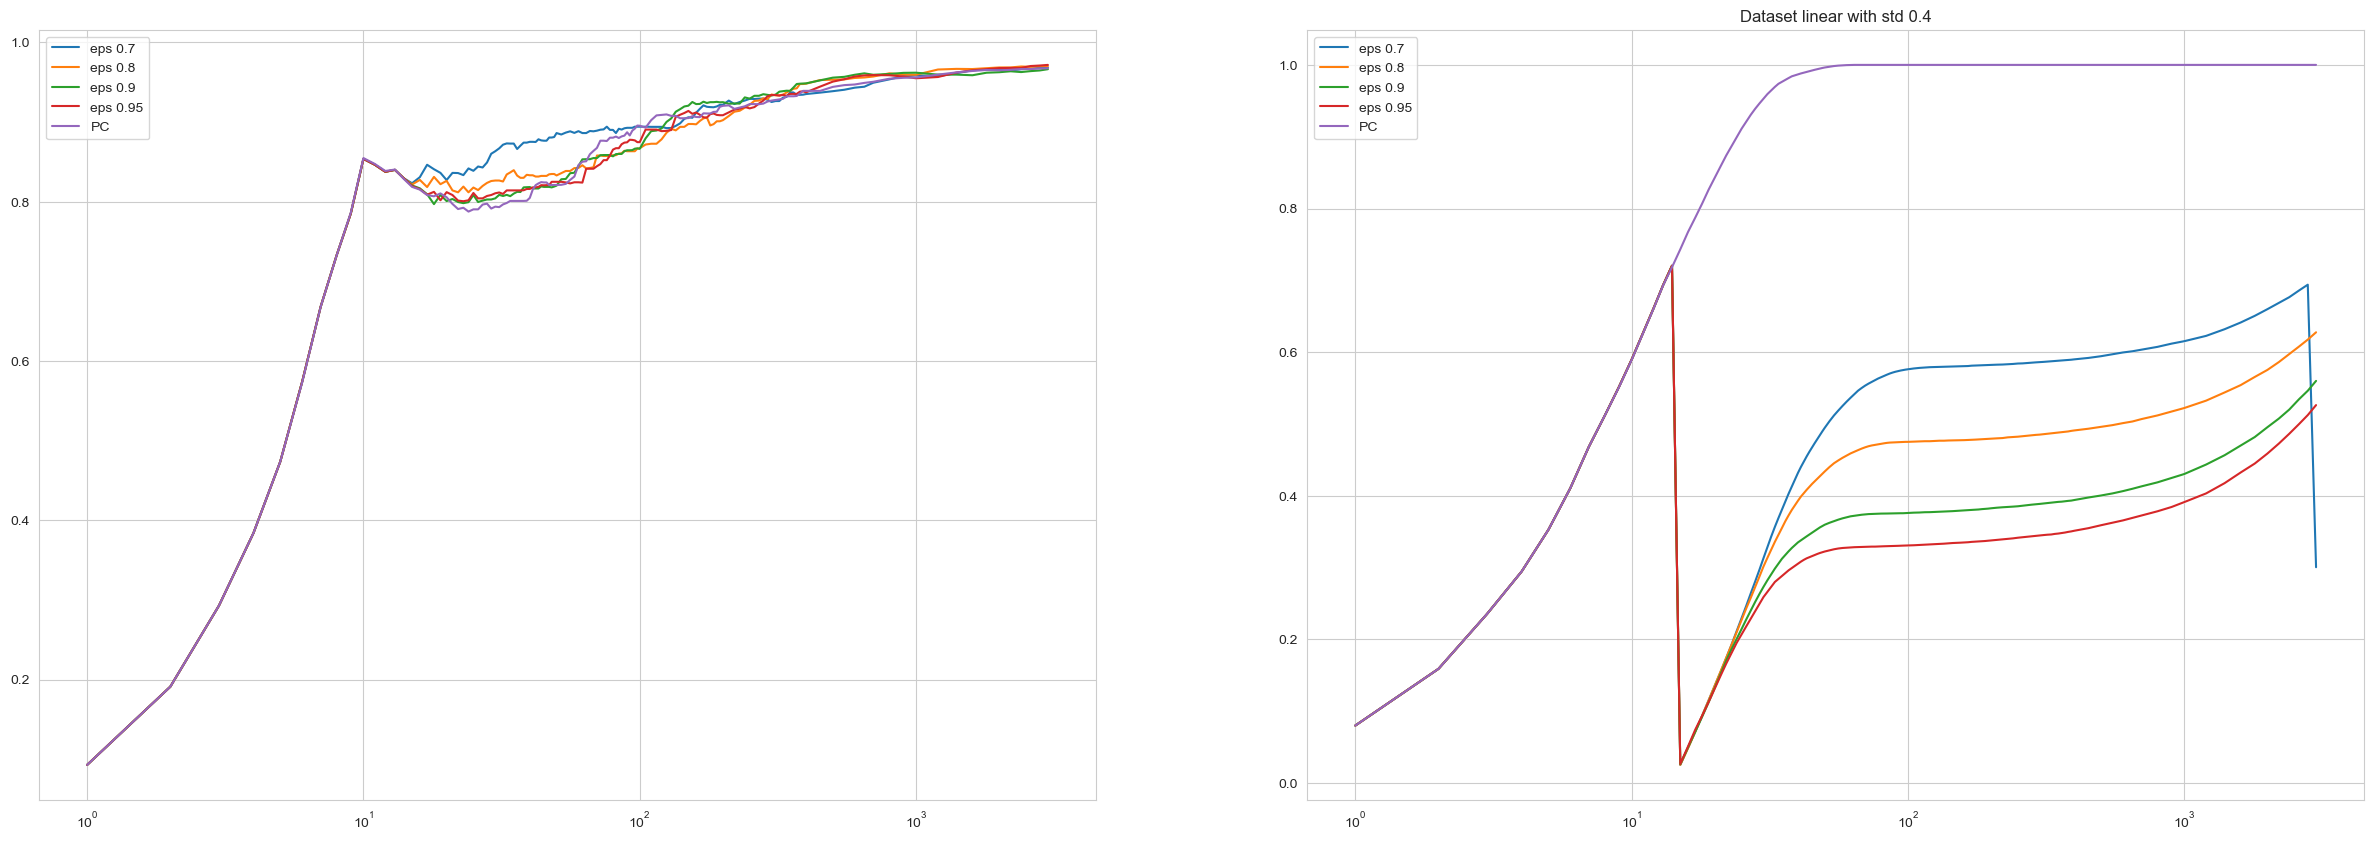

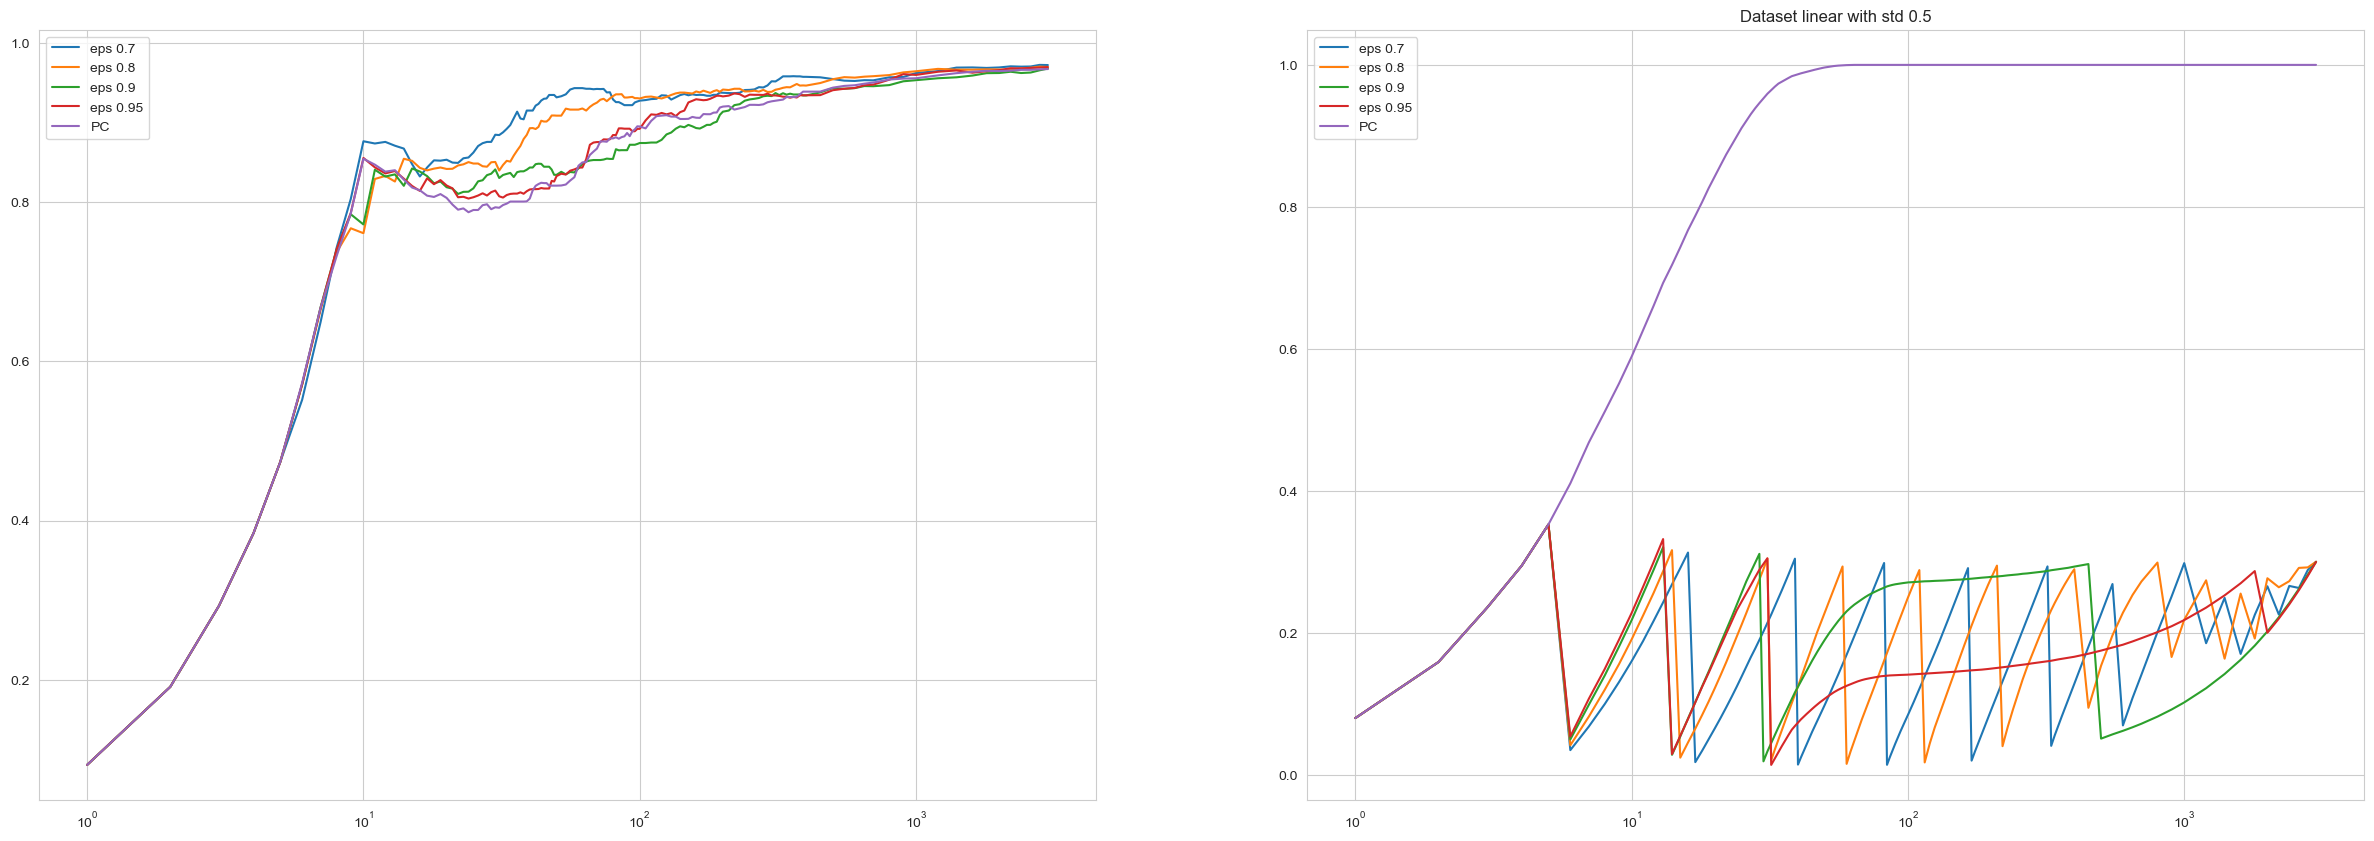

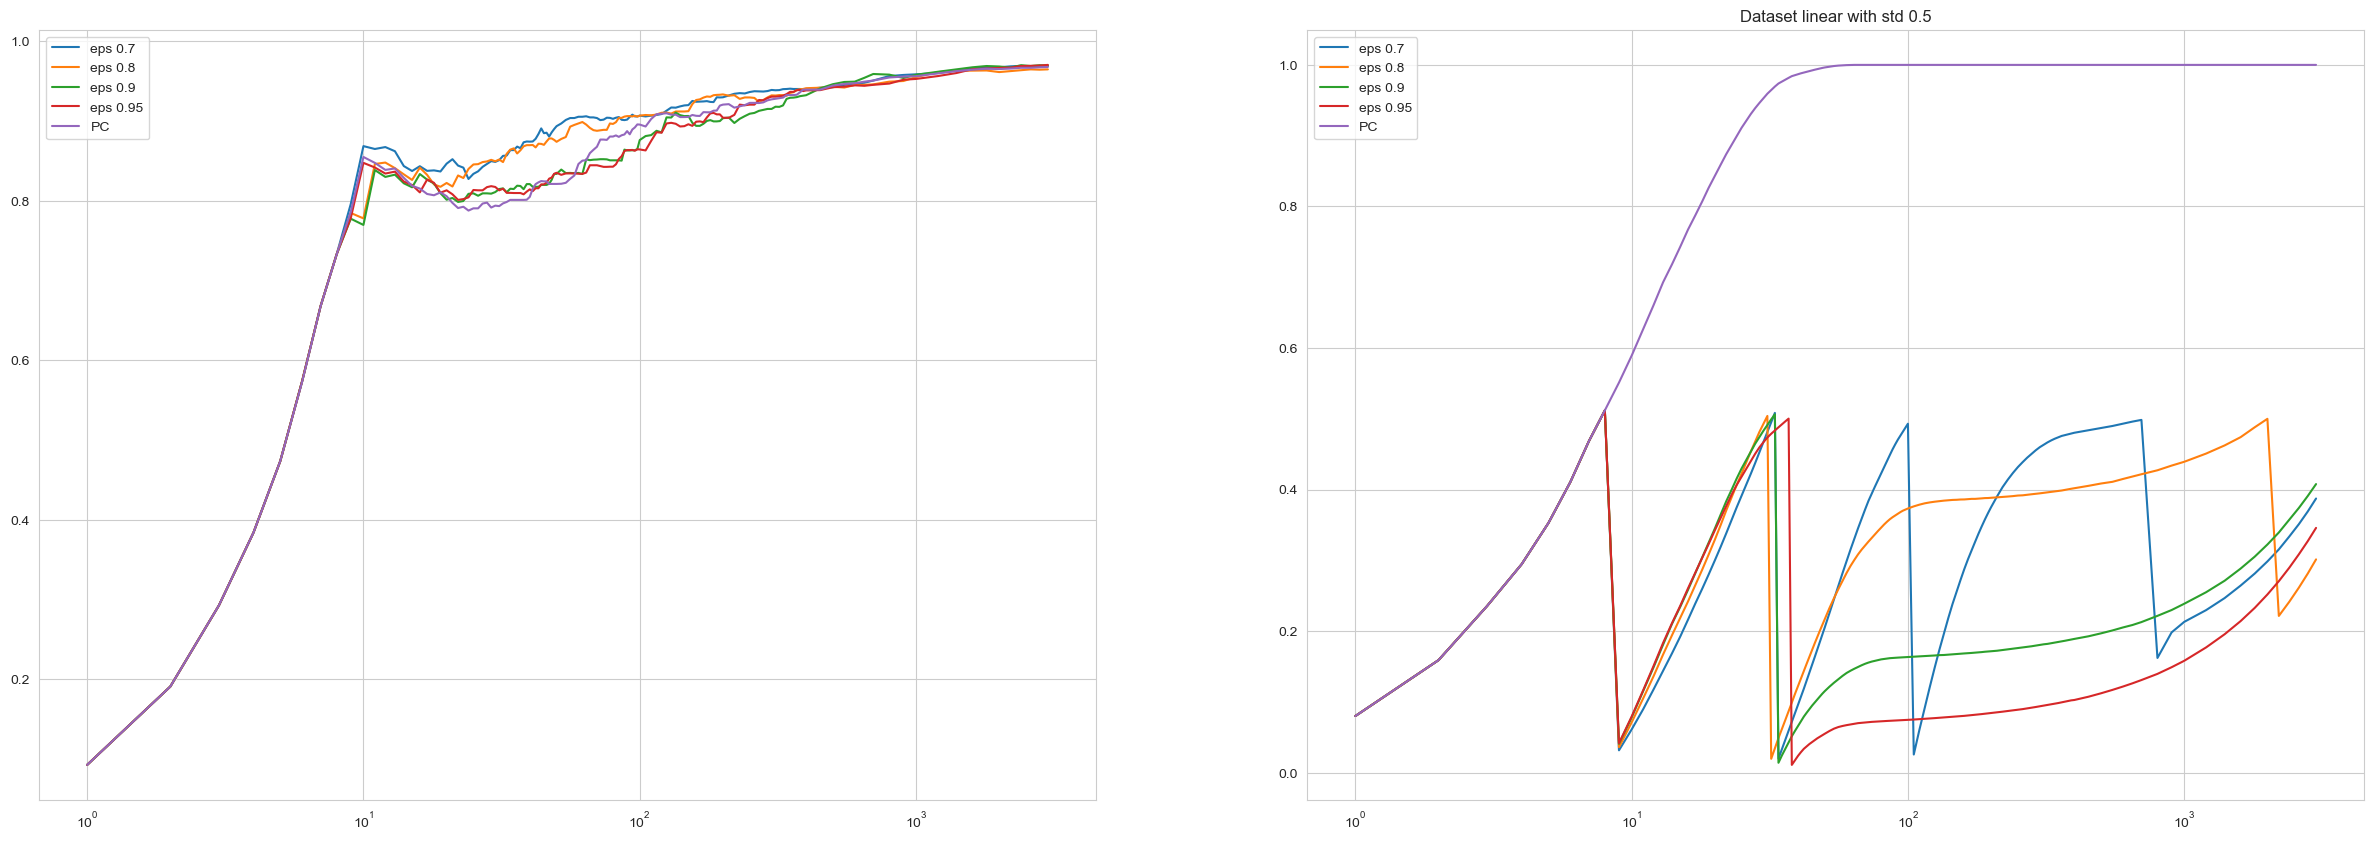

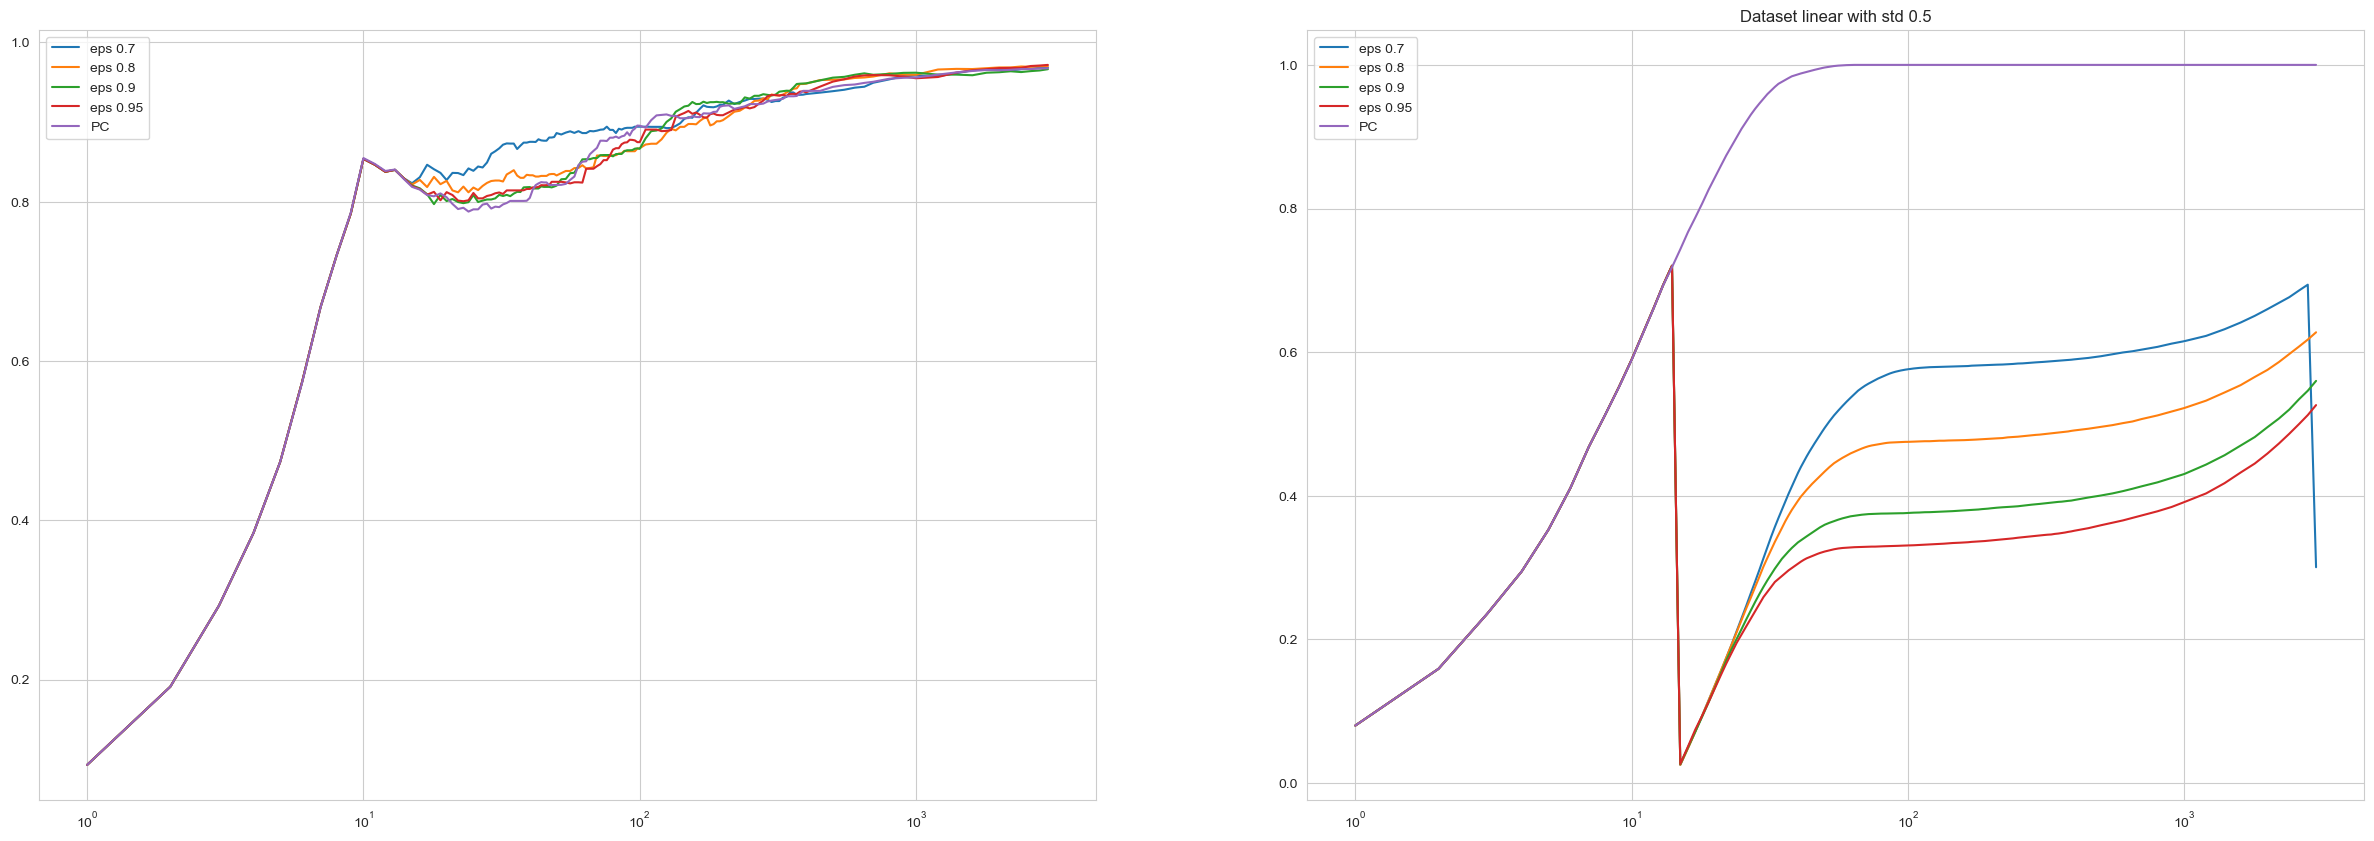

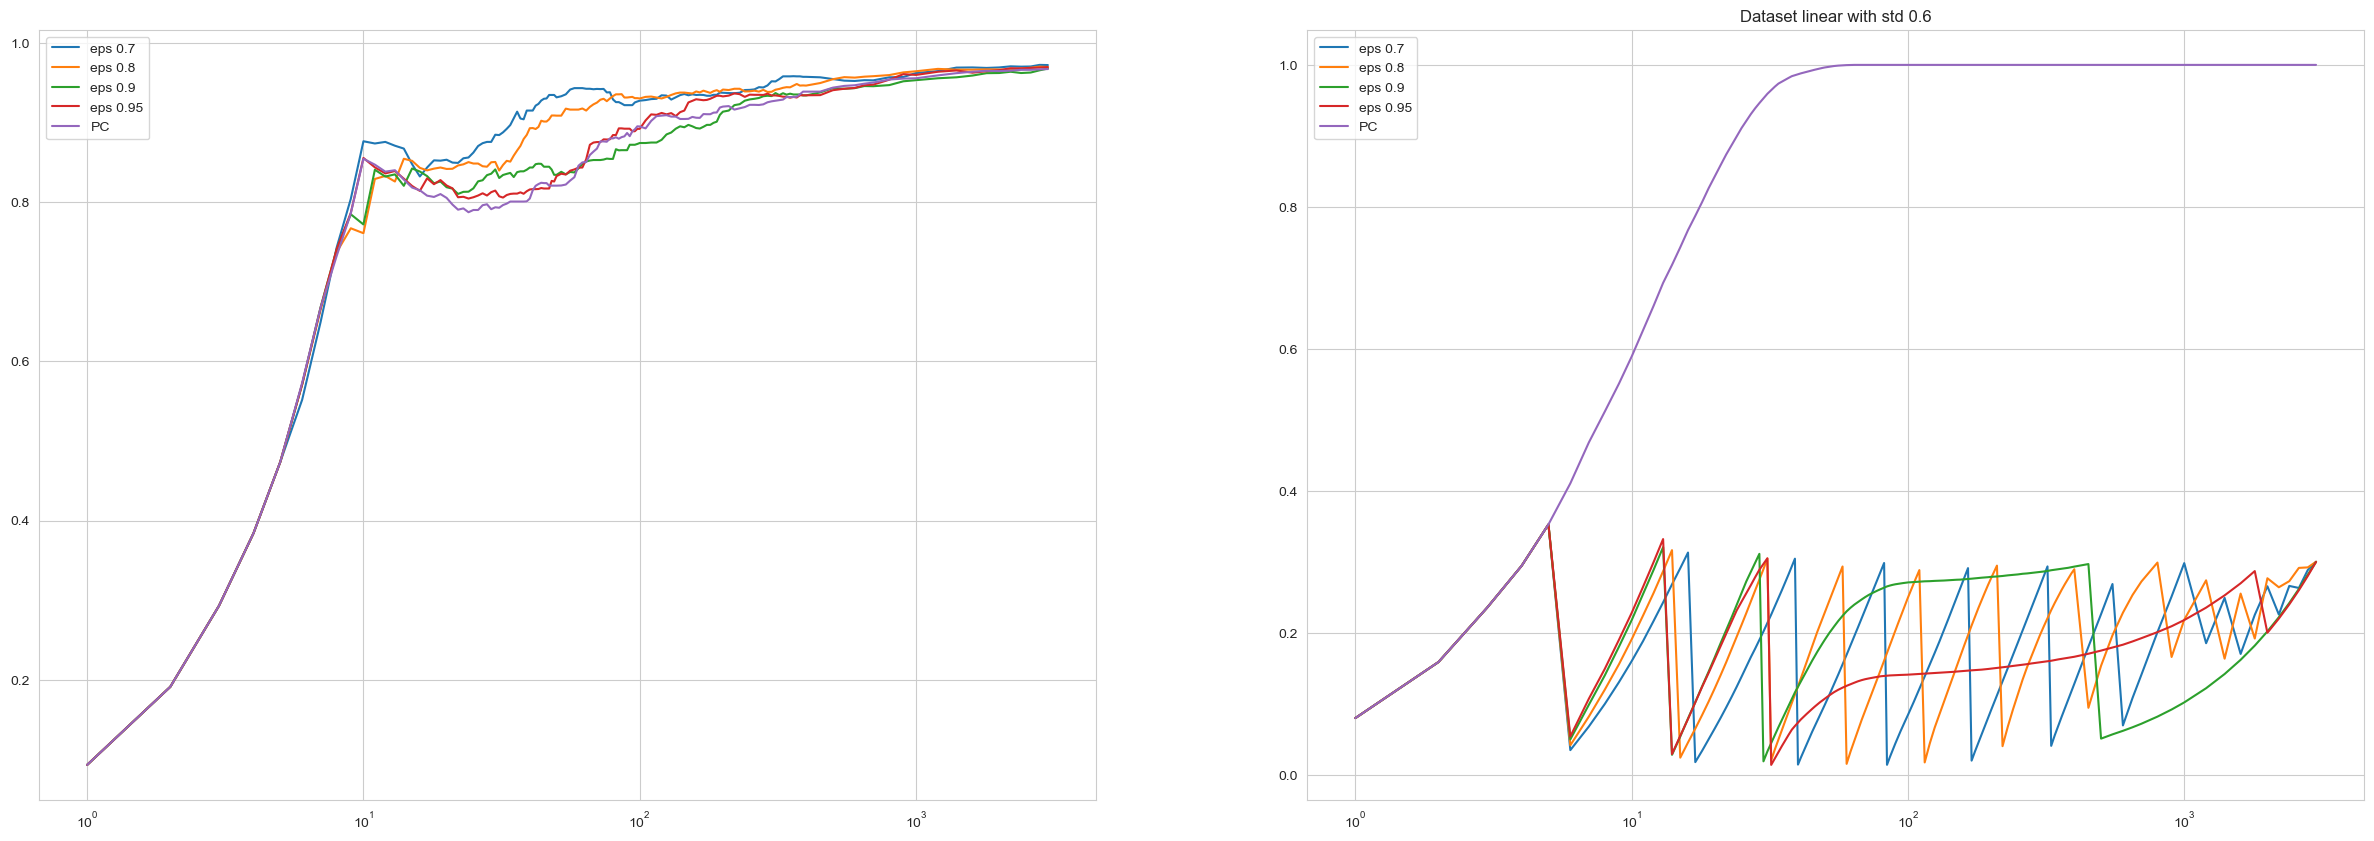

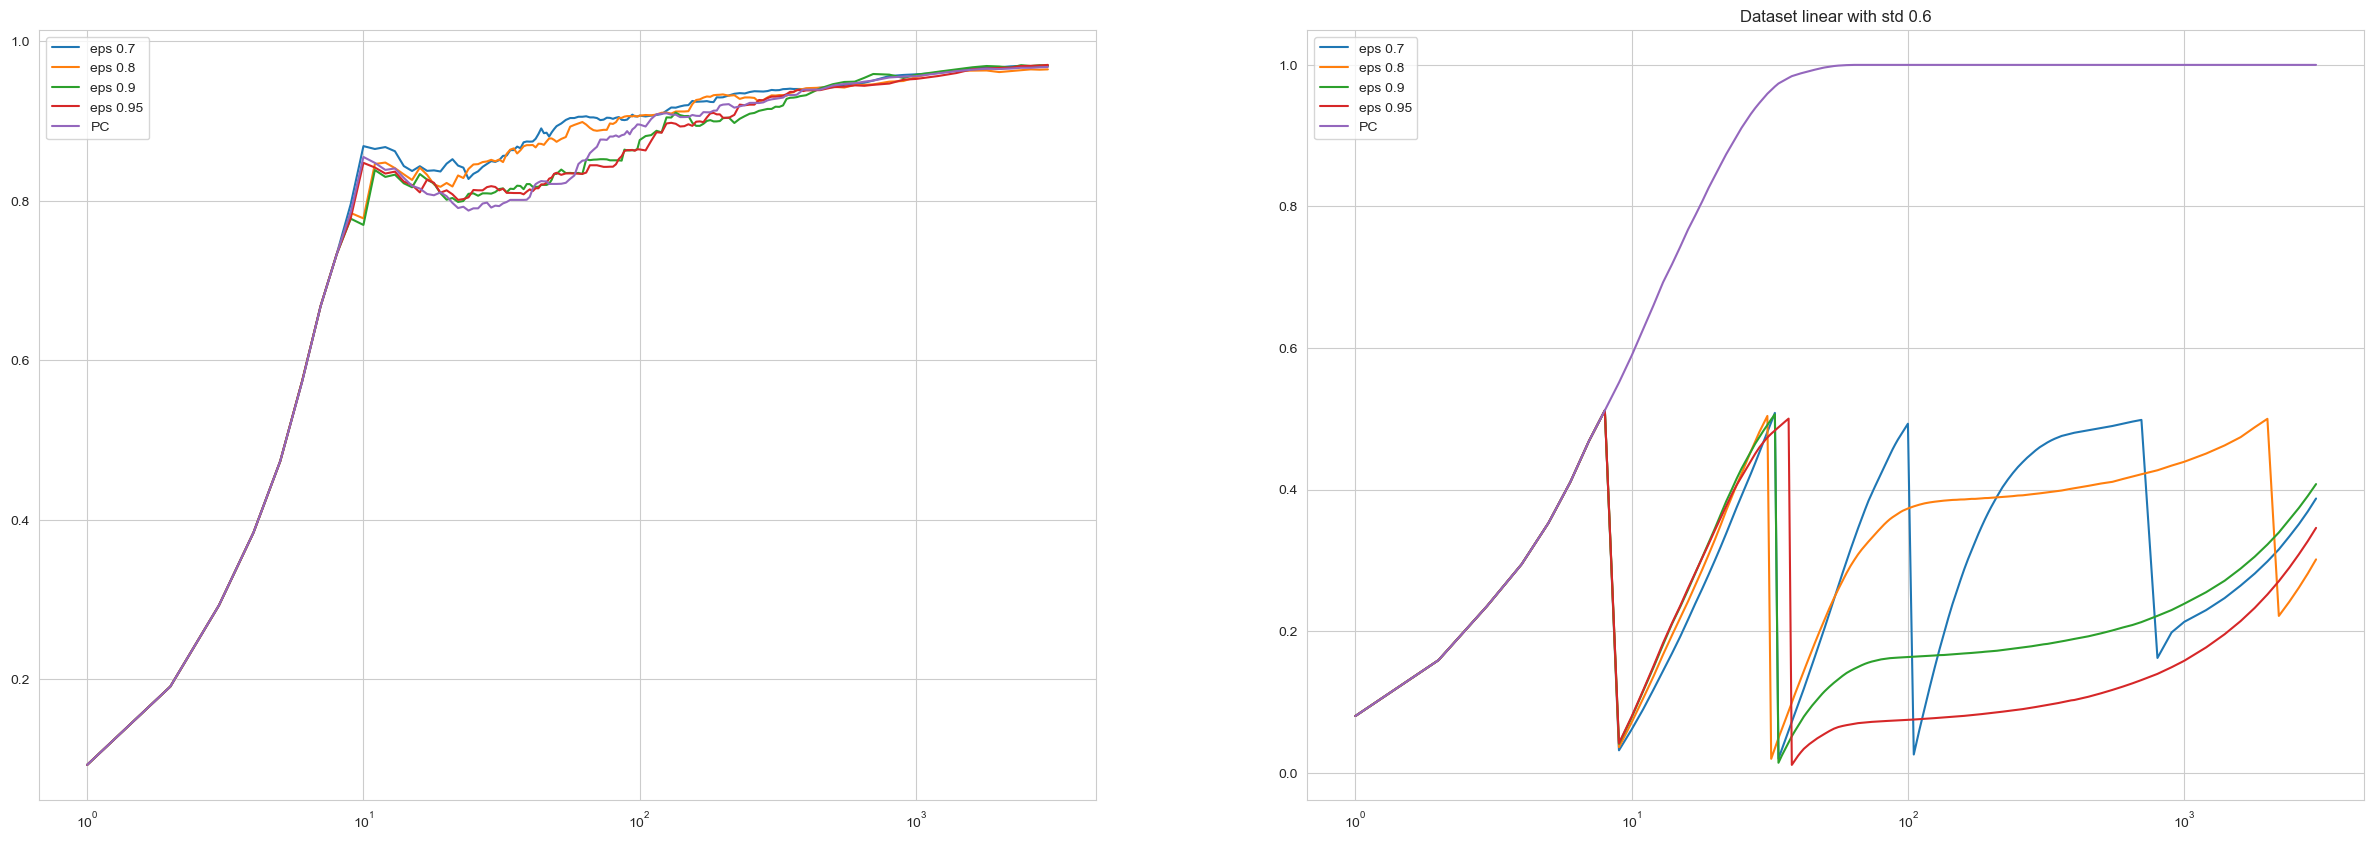

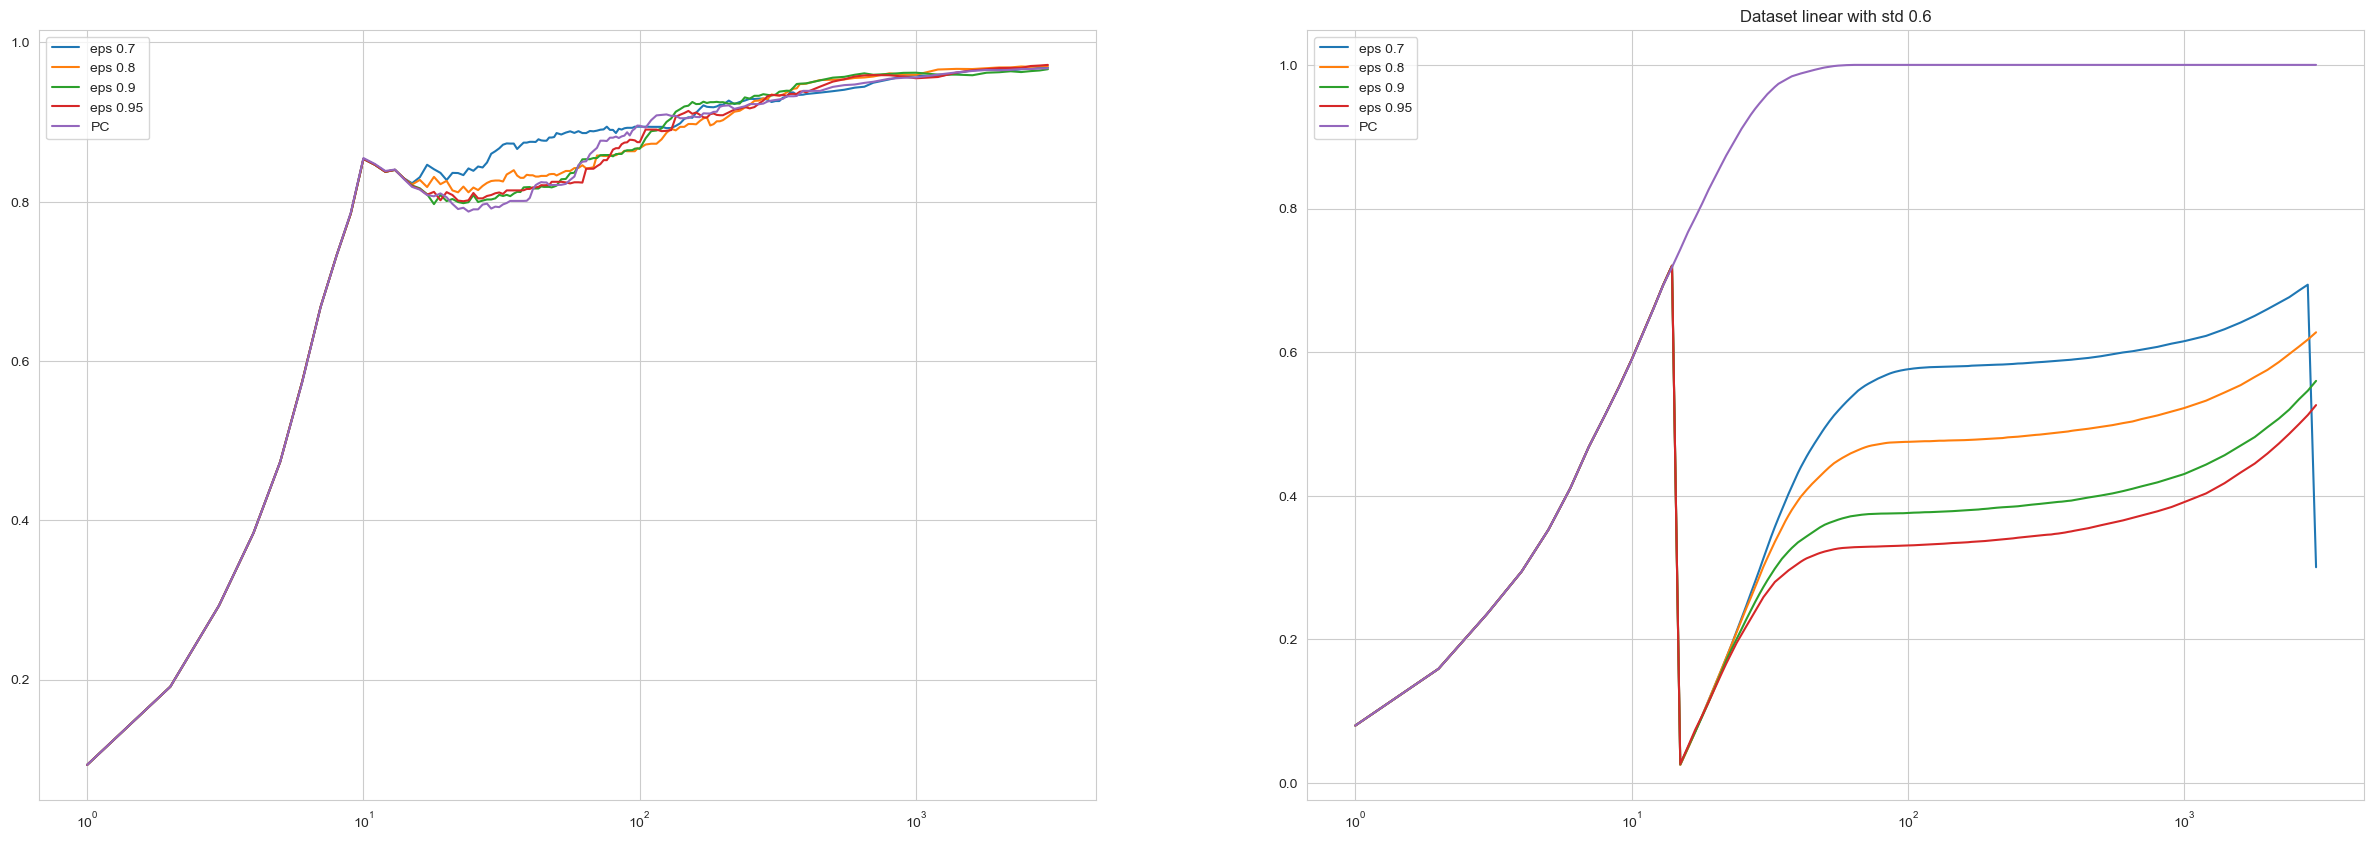

In [43]:
args.run="toy_runs"
args.tsh=0.25
args.separable="linear"
args.algorithm="coverpc"
args.budget="low"
for std in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    args.std= std
    plot_coverpc_performance(args, n_seeds=1, save=False)